In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_theme(style='darkgrid', palette='crest')
import matplotlib.pyplot as plt


from sktime.forecasting.compose import ForecastingPipeline
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.bats import BATS
from sktime.forecasting.trend import TrendForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.croston import Croston
from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.compose import StackingForecaster

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
leveranser_flytande = pd.read_table('../data/to-use/leveranser-flytande-bransle-region-ar.csv', sep=',')
elproduction_bransleanvandning = pd.read_table('../data/to-use/elproduction-bransleanvandning-region-produktionssatt-bransletyp-ar.csv', sep=',')
fjarrvarmeproduktion = pd.read_table('../data/to-use/fjarrvarmeproduktion-region-produktionssatt-bransletyp-ar.csv', sep=',')
slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')
bransleforbrukning = pd.read_table('../data/to-use/branslefarbrukning-far-produktion-per-ar.csv', sep=',')
energidata = pd.read_table('../data/to-use/energidata-per-ar.csv', sep=',')

datasets = [leveranser_flytande, elproduction_bransleanvandning, 
            fjarrvarmeproduktion, slutanvandning, bransleforbrukning, energidata]


## Fill NAs
leveranser_flytande.m3 = leveranser_flytande.m3.fillna(method='ffill')
fjarrvarmeproduktion.MWh = fjarrvarmeproduktion.MWh.interpolate()
# slutanvandning = slutanvandning.fillna('fffill')
energidata.MWh = energidata.MWh.fillna(method='ffill')

## Remove '..' values
bransleforbrukning = bransleforbrukning.replace('..', 0)
bransleforbrukning.branslefarbrukning = bransleforbrukning.branslefarbrukning.astype(int)

energidata = energidata.replace('..', 0)
energidata.MWh = energidata.MWh.astype(int)

# Slice dataset for regions
leveranser_flytande = leveranser_flytande[leveranser_flytande.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
elproduction_bransleanvandning = elproduction_bransleanvandning[elproduction_bransleanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion[fjarrvarmeproduktion.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
slutanvandning = slutanvandning[slutanvandning.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)
energidata = energidata[energidata.region.isin(['0160 T�by', '0117 �ster�ker', '0180 Stockholm', '0980 Gotland', '01 Stockholms l�n', '22 V�sternorrlands l�n', '09 Gotlands l�n', '00 Riket', '2581 Pite�', '1480 G�teborg'])].reset_index(drop=True)


## Group datasets
leveranser_flytande = leveranser_flytande.groupby(['region', 'ar', 'fornybar_bransletyp'], as_index=False).agg(Sum=('m3', np.sum)).reset_index(drop=True)
elproduction_bransleanvandning_grouped = elproduction_bransleanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
fjarrvarmeproduktion = fjarrvarmeproduktion.groupby(['region', 'ar', 'fornybar_bransletyp', 'fornybar_produktionssatt'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
slutanvandning = slutanvandning.groupby(['region', 'ar', 'fornybar_bransletyp', 'forbrukarkategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)
bransleforbrukning = bransleforbrukning.groupby(['ar', 'fornybar_bransletyp', 'produktionsslag'], as_index=False).agg( Sum=('branslefarbrukning', np.sum)).reset_index(drop=True)
energidata = energidata.groupby(['region', 'ar', 'fornybar_energityp', 'fornybar_kategori'], as_index=False).agg(Sum=('MWh', np.sum)).reset_index(drop=True)

bransleforbrukning.Sum = bransleforbrukning.Sum.astype(float)


C:\Users\markella.nikolopoulo\AppData\Local\Temp\ipykernel_4428\4031090058.py:4: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  slutanvandning = pd.read_table('../data/to-use/slutanvandning-region-forbrukarkategori-bransletyp-kategori-energityp-ar.csv', sep=',')


00 Riket
fornybar


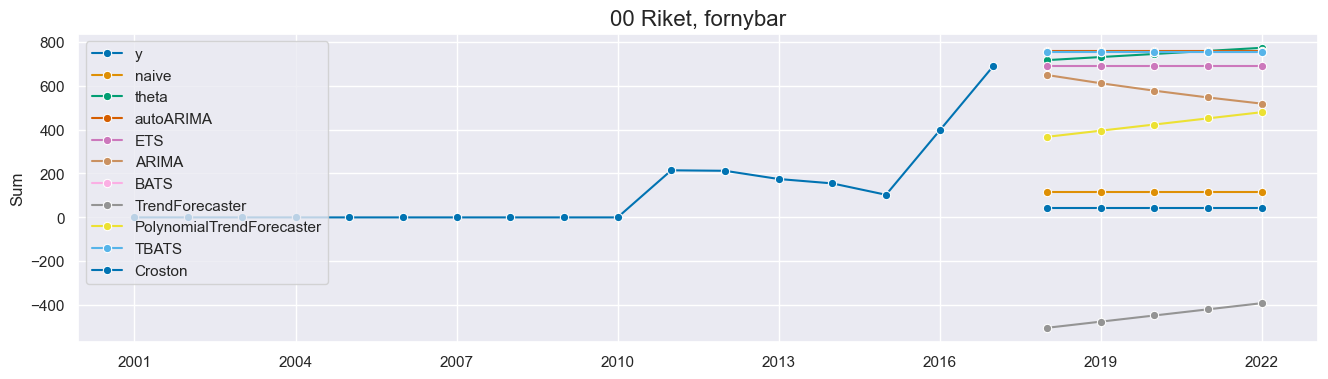

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


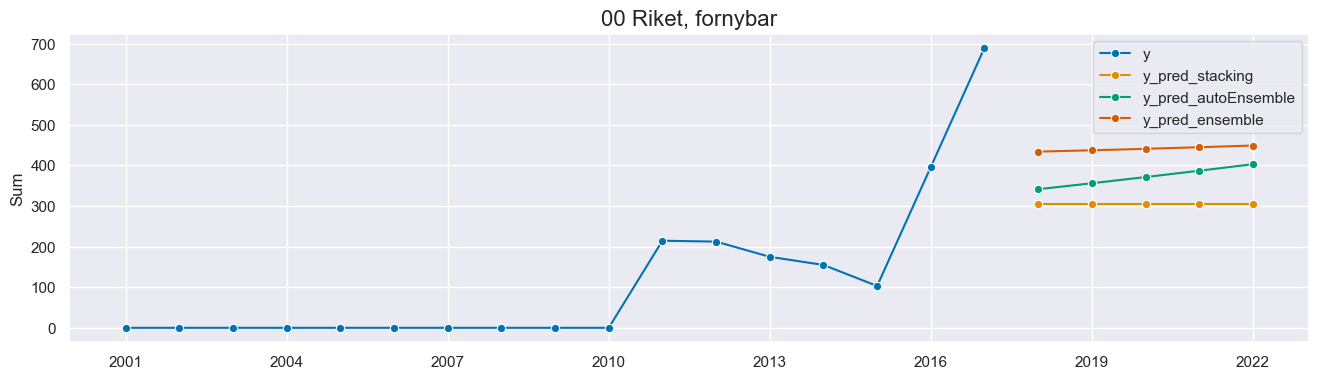

01 Stockholms l�n
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


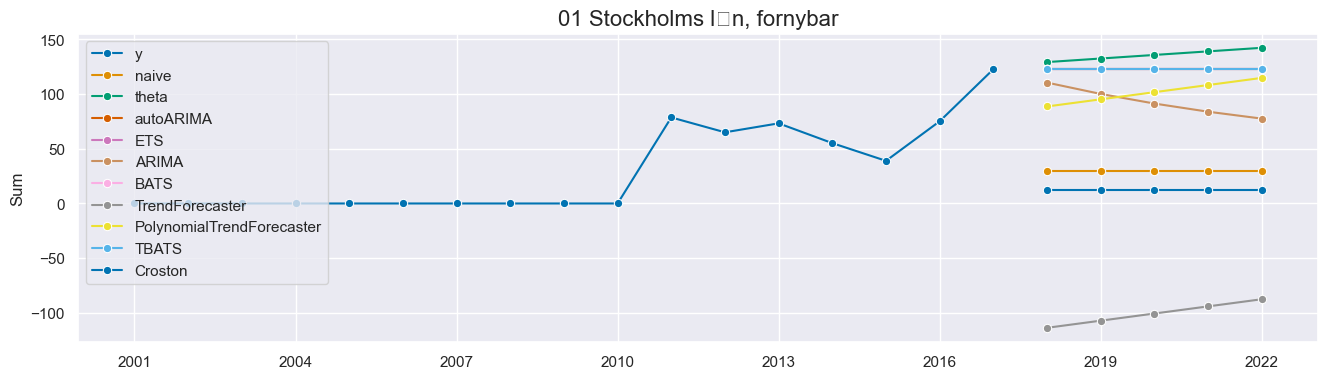

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


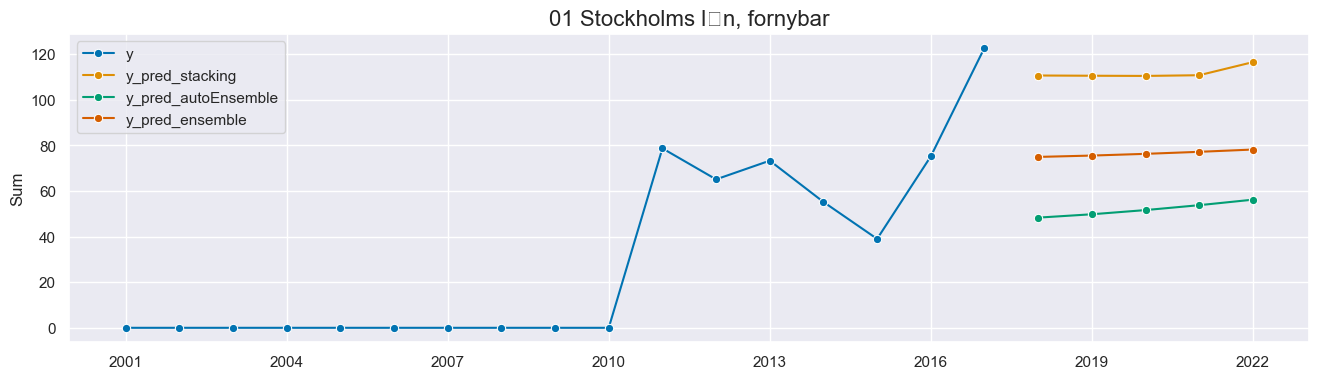

0117 �ster�ker
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


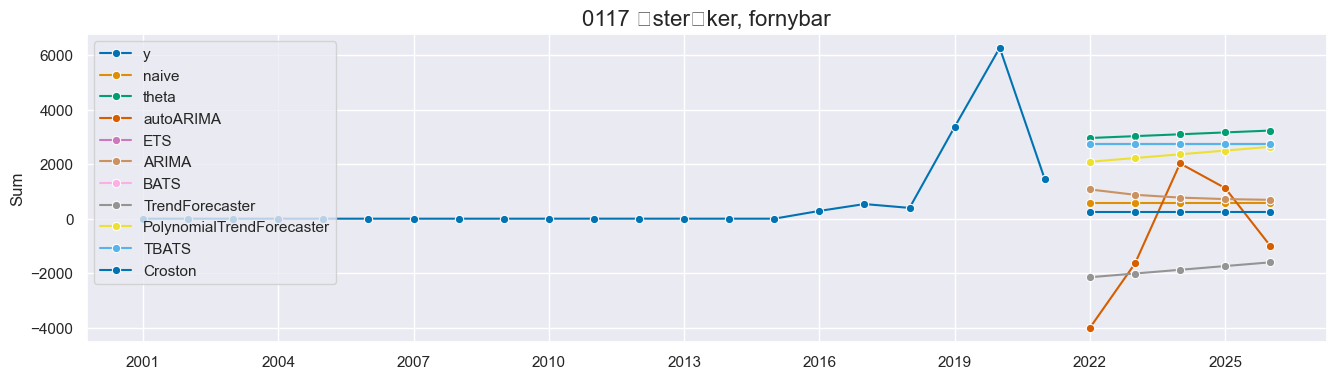

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,1)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning

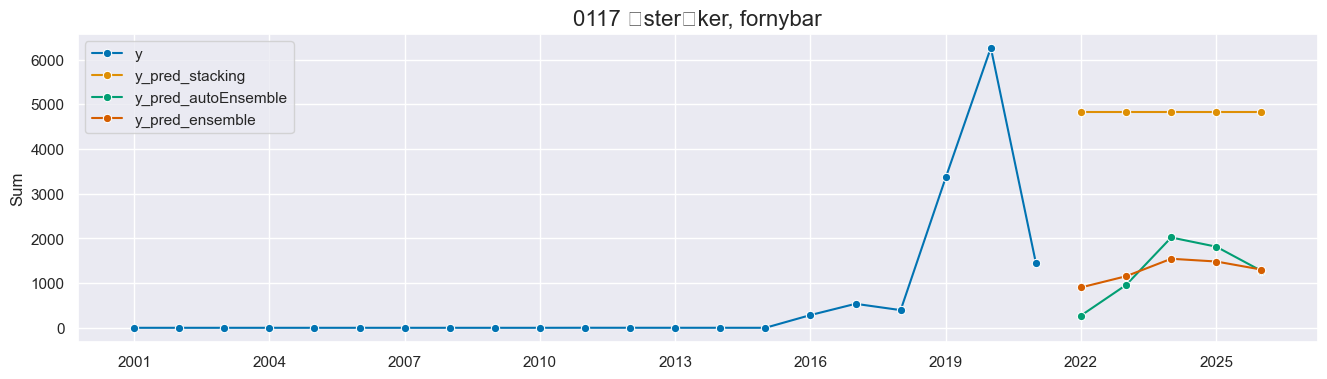

0160 T�by
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


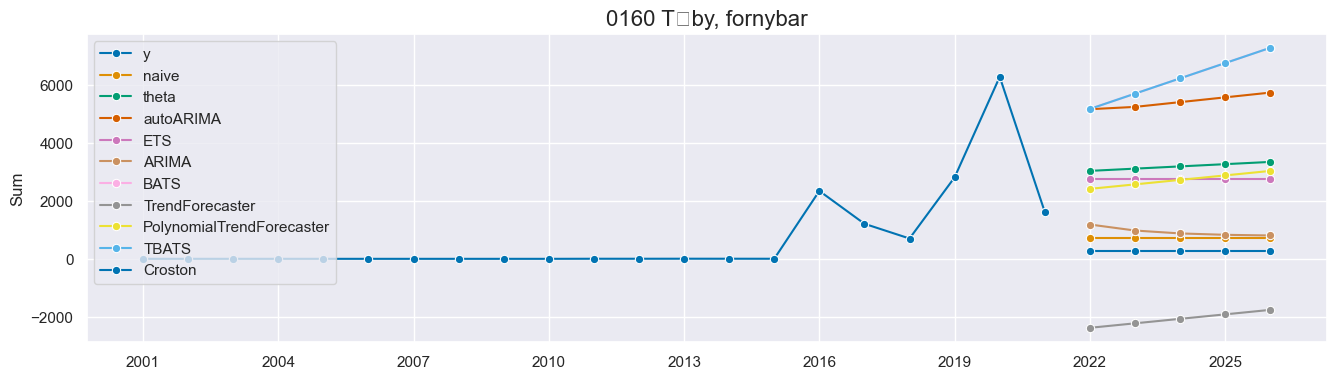

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


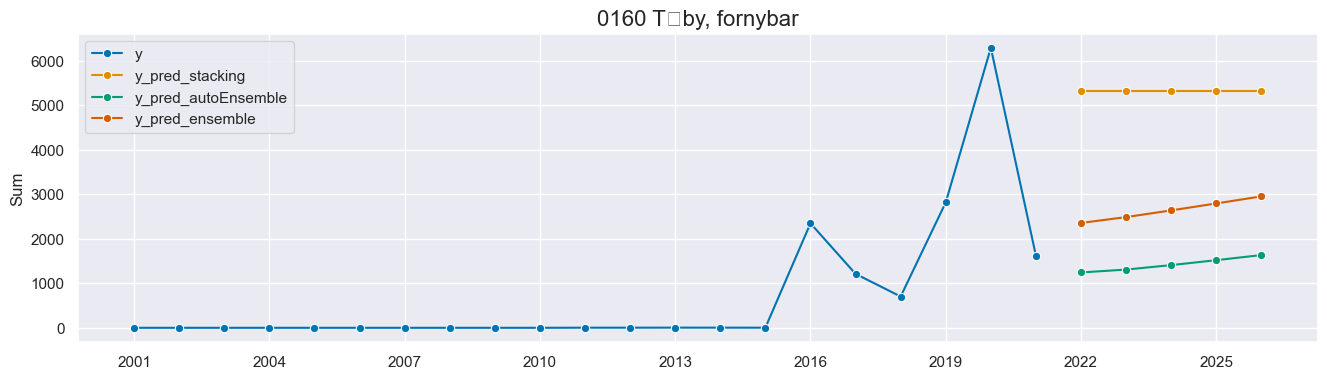

0180 Stockholm
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


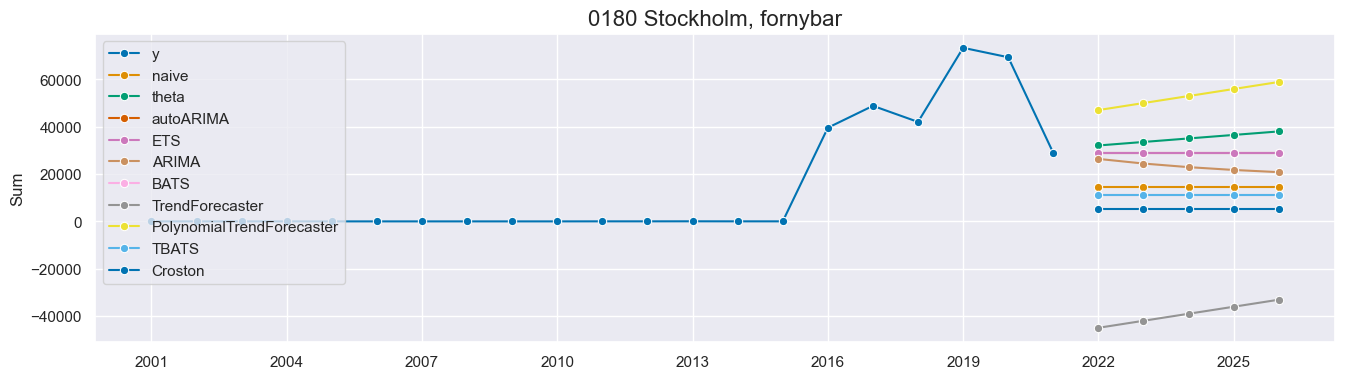

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thi

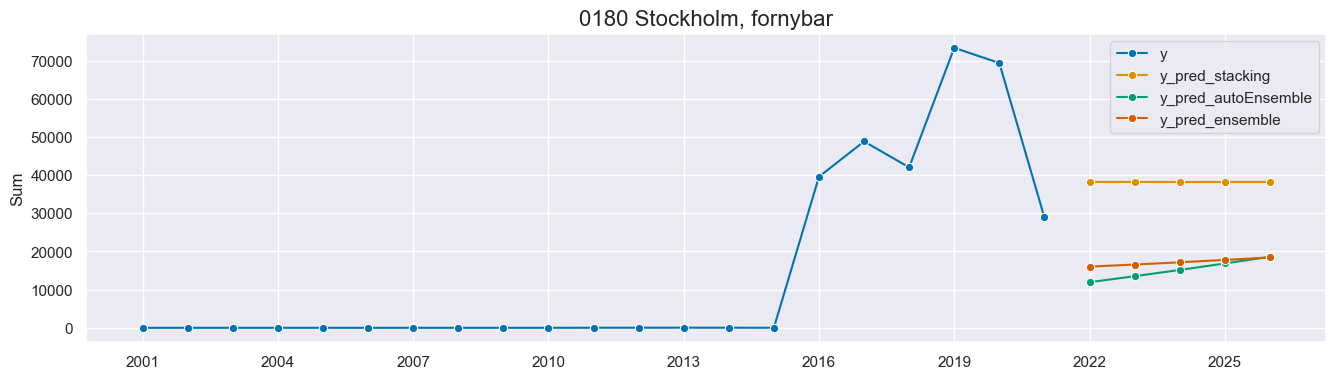

09 Gotlands l�n
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


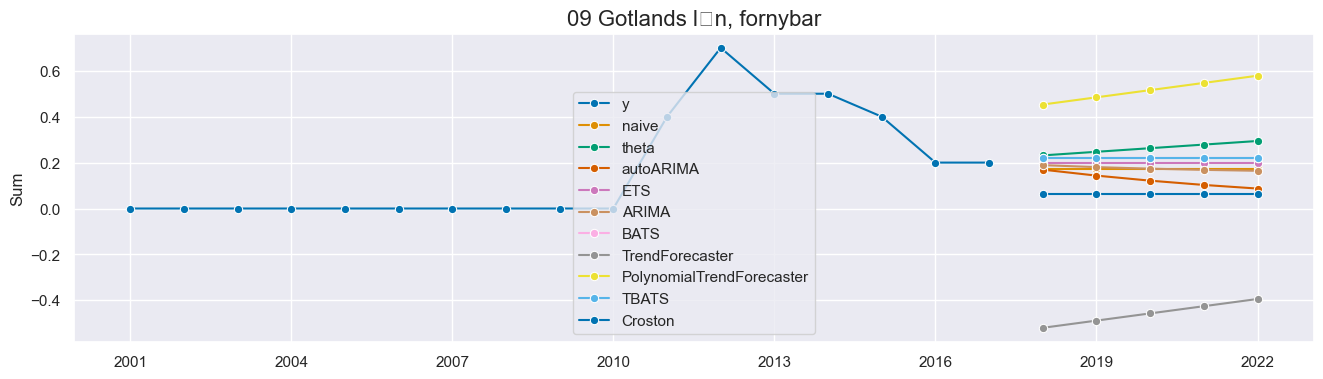

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,3)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,3)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning

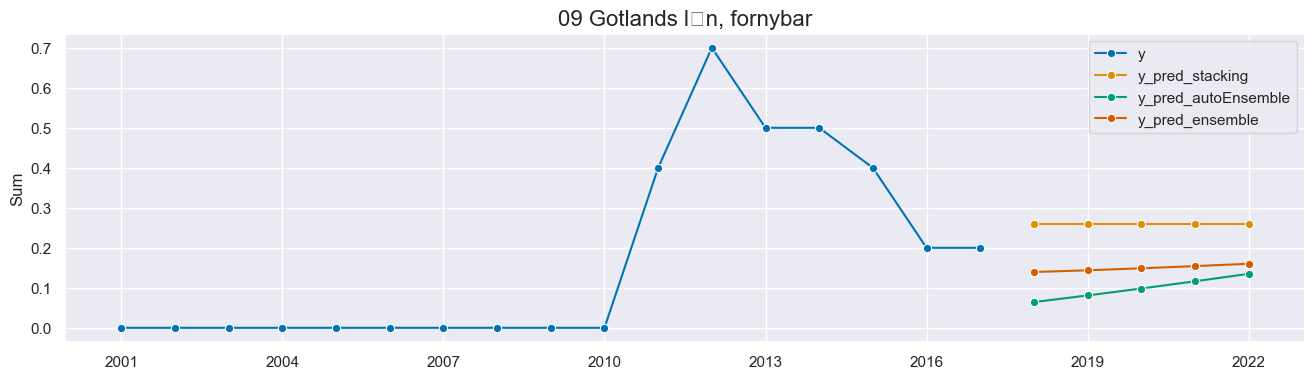

0980 Gotland
fornybar


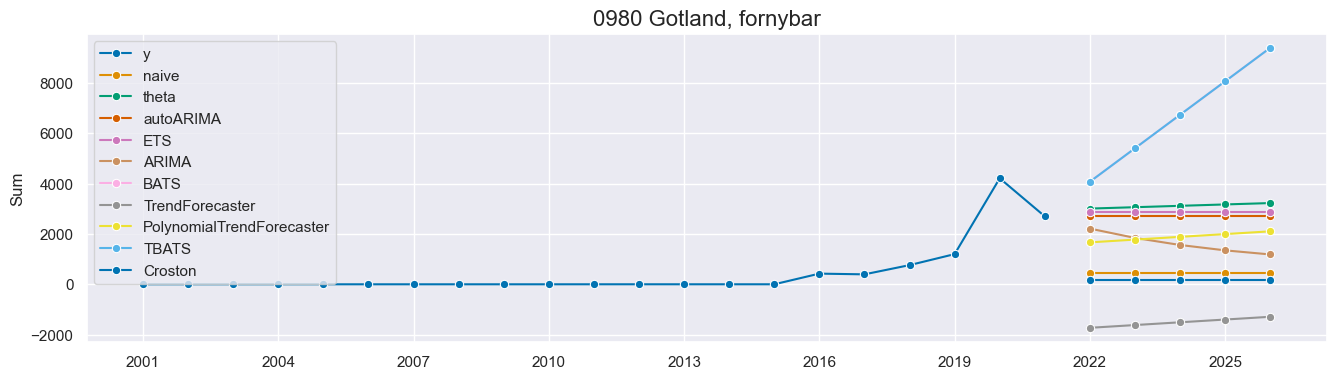

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


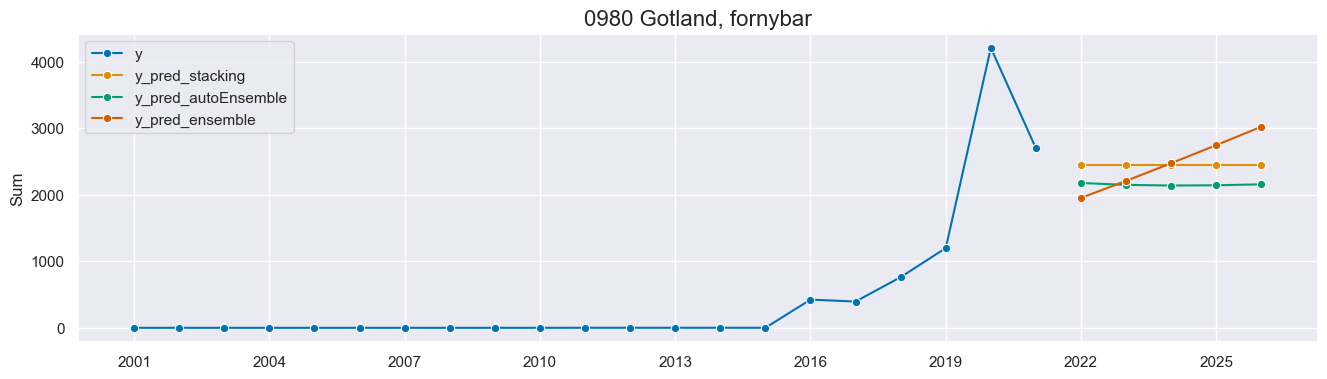

1480 G�teborg
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


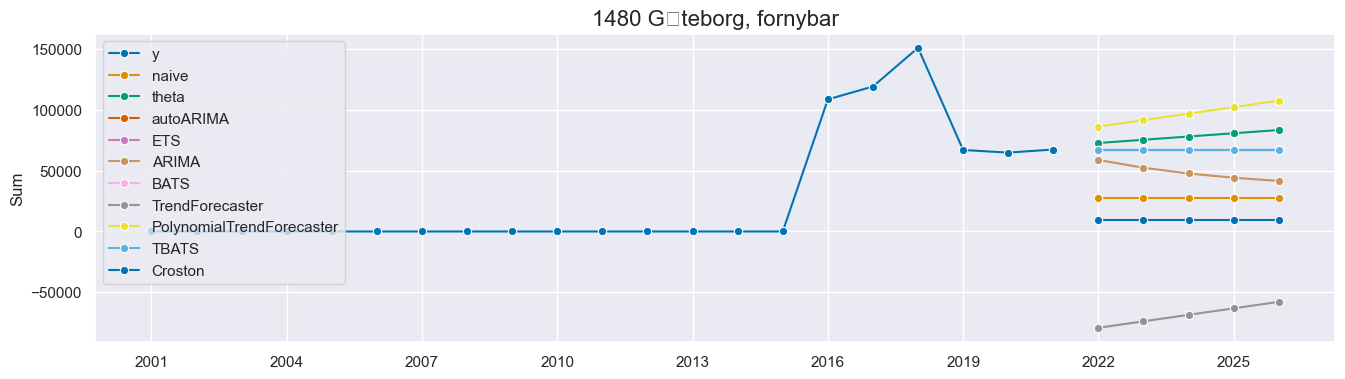

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thi

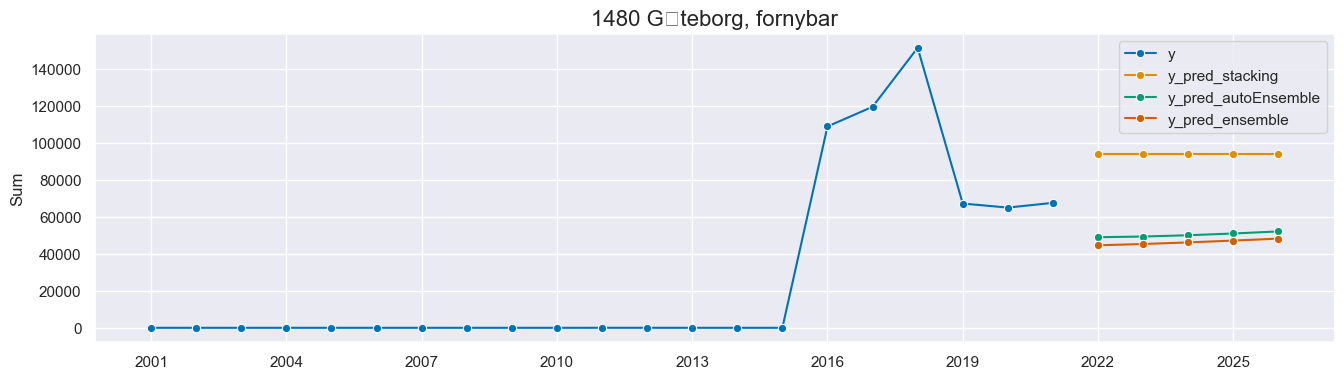

22 V�sternorrlands l�n
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


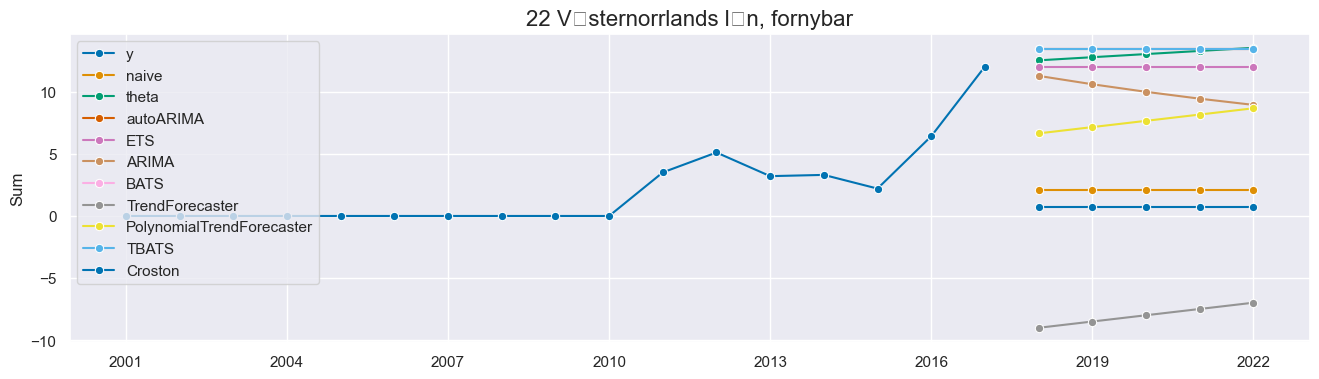

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


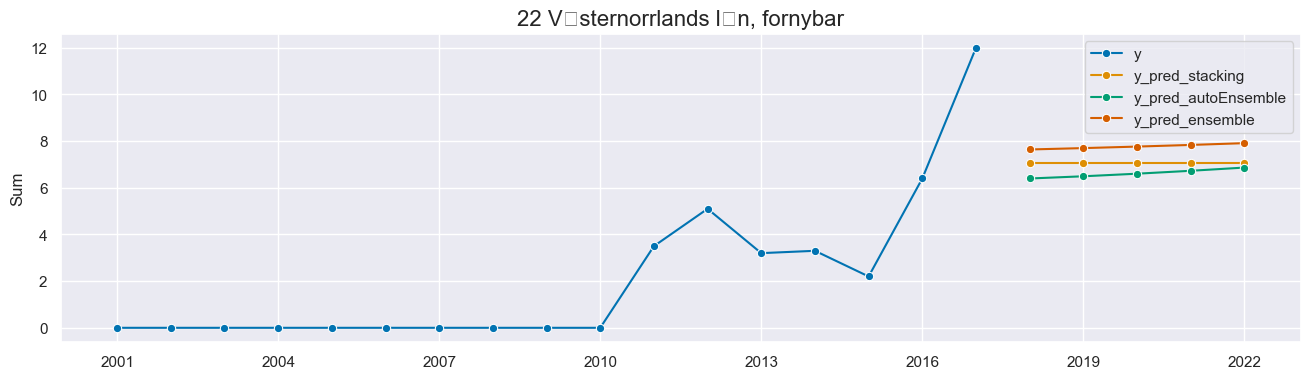

2581 Pite�
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


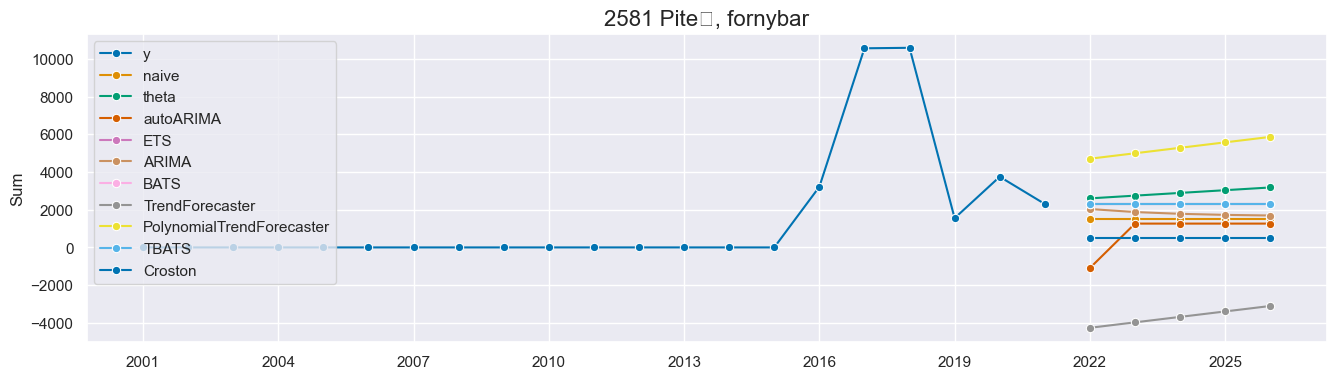

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


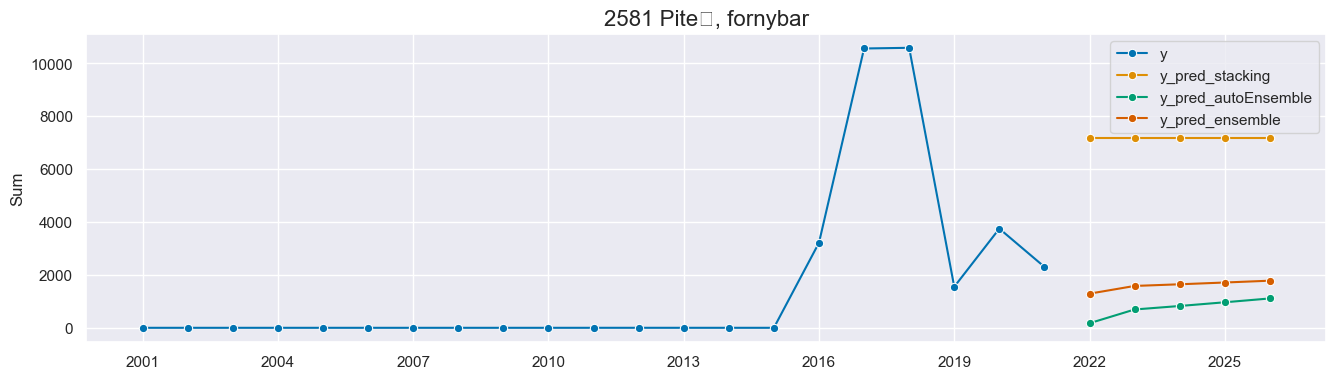

In [3]:
# leveranser_flytande

for region in leveranser_flytande.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = leveranser_flytande[leveranser_flytande.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        
        if not data.empty:
            print(region)
            print(fornybar_bransletyp)
           

            data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
            data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

            y = data[['Sum']].squeeze()
            
            # create forecasting horizon
            fh = ForecastingHorizon(
                    pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
            )
            
            # Instantiate NaiveForecaster:
            forecaster = NaiveForecaster(strategy='mean').fit(y)
            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Instantiate Theta:
            forecaster = ThetaForecaster(deseasonalize=False).fit(y)
            # Predict Thet:
            y_pred_theta = forecaster.predict(fh=fh)
            
            # Instantiate autoARIMA
            forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
            # Predict autoARIMA 
            y_pred_autoARIMA = forecaster.predict(fh)

            # Instantiate AutoETS
            forecaster = AutoETS(seasonal=None).fit(y)
            # Predict AutoETS 
            y_pred_ETS = forecaster.predict(fh)

            # Instantiate ARIMA
            forecaster = ARIMA(suppress_warnings=True).fit(y)
            # Predict ARIMA 
            y_pred_ARIMA = forecaster.predict(fh)

            # Instantiate BATS
            forecaster = BATS(show_warnings=False).fit(y)
            # Predict BATS 
            y_pred_BATS = forecaster.predict(fh)

            # Instantiate TrendForecaster
            forecaster = TrendForecaster().fit(y)
            # Predict TrendForecaster 
            y_pred_TrendForecaster = forecaster.predict(fh)

            # Instantiate PolynomialTrendForecaster
            forecaster = PolynomialTrendForecaster().fit(y)
            # Predict PolynomialTrendForecaster 
            y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
            
            # Instantiate TBATS
            forecaster = TBATS(show_warnings=False).fit(y)
            # Predict TBATS 
            y_pred_TBATS = forecaster.predict(fh)
            
            # Instantiate Croston
            forecaster = Croston().fit(y)
            # Predict Croston 
            y_pred_Croston = forecaster.predict(fh)
            
            # Check it out:
            fig = plot_series(y, y_pred, 
                                y_pred_theta, 
                                y_pred_autoARIMA, 
                                y_pred_ETS, 
                                y_pred_ARIMA, 
                                y_pred_BATS, 
                                y_pred_TrendForecaster, 
                                y_pred_PolynomialTrendForecaster, 
                                y_pred_TBATS, 
                                y_pred_Croston, 
                                labels=["y", 
                                    "naive", 
                                    "theta", 
                                    "autoARIMA", 
                                    "ETS", 
                                    "ARIMA", 
                                    "BATS", 
                                    "TrendForecaster", 
                                    "PolynomialTrendForecaster", 
                                    "TBATS", 
                                    "Croston"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig)

            forecasters = [
                ("NaiveForecaster", NaiveForecaster(strategy='mean')),
                ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                ("AutoETS", AutoETS(seasonal=None)),
                ("ARIMA", ARIMA(suppress_warnings=True)),
                ("BATS", BATS(show_warnings=False)),
                ("TBATS", TBATS(show_warnings=False)),
                ("TrendForecaster", TrendForecaster()),
                ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                ("Croston", Croston()),
            ]

            # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
            stackingForecaster = StackingForecaster(forecasters=forecasters)
            stackingForecaster.fit(y=y, fh=fh)
            y_pred_stacking = stackingForecaster.predict()

            # Automatically find best weights for the ensembled forecasters.
            autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
            autoEnsembleForecaster.fit(y=y)
            y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

            # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
            ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
            ensembleForecaster.fit(y=y)
            y_pred_ensemble = ensembleForecaster.predict(fh=fh)

            # Check it out:
            fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig)


            # print("----------------")   

        # else:
        #     print("----------------")   




00 Riket
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


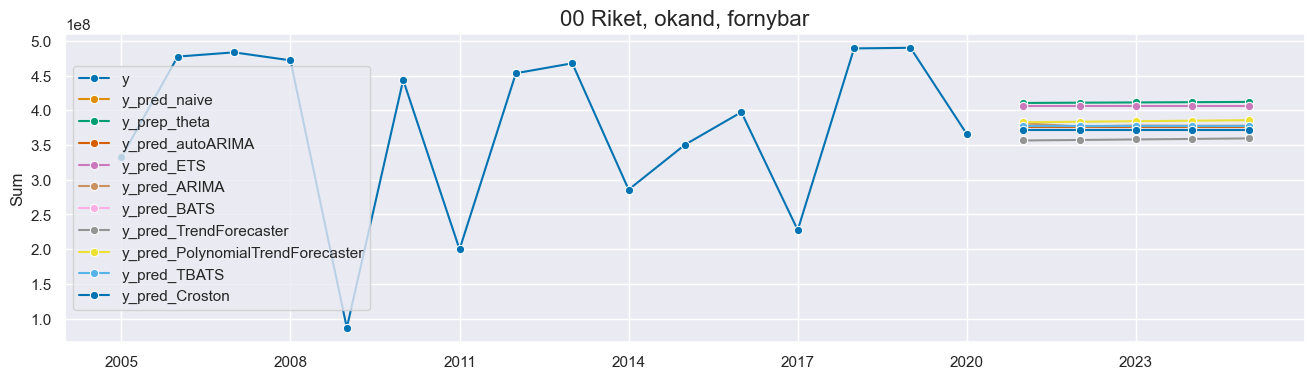

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

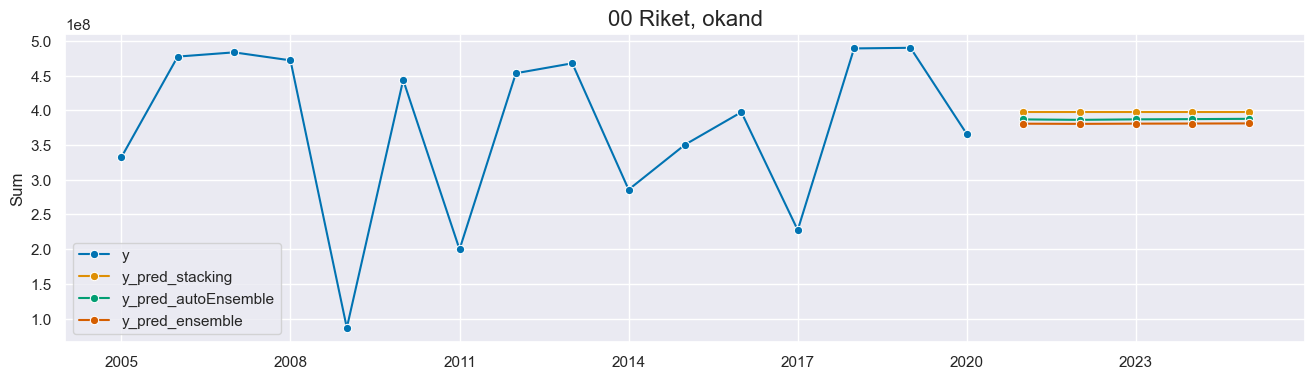

01 Stockholms l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


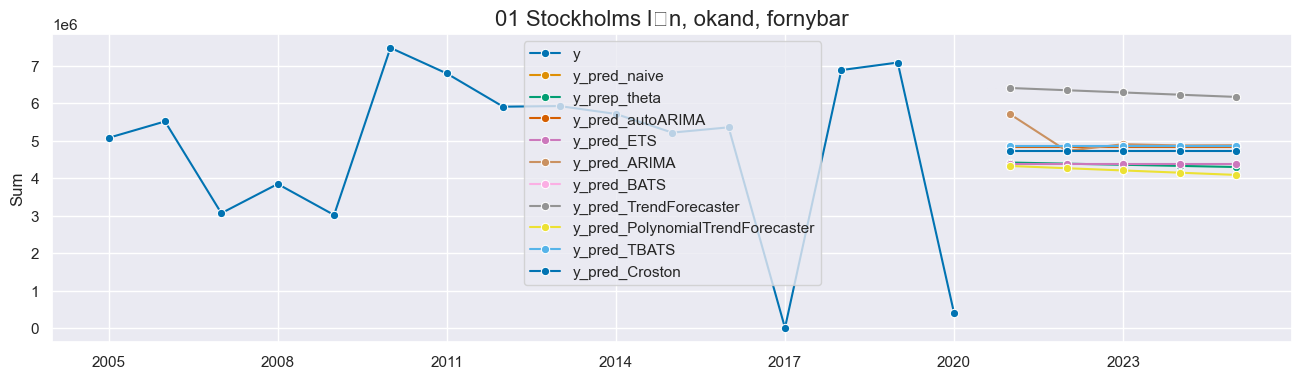

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

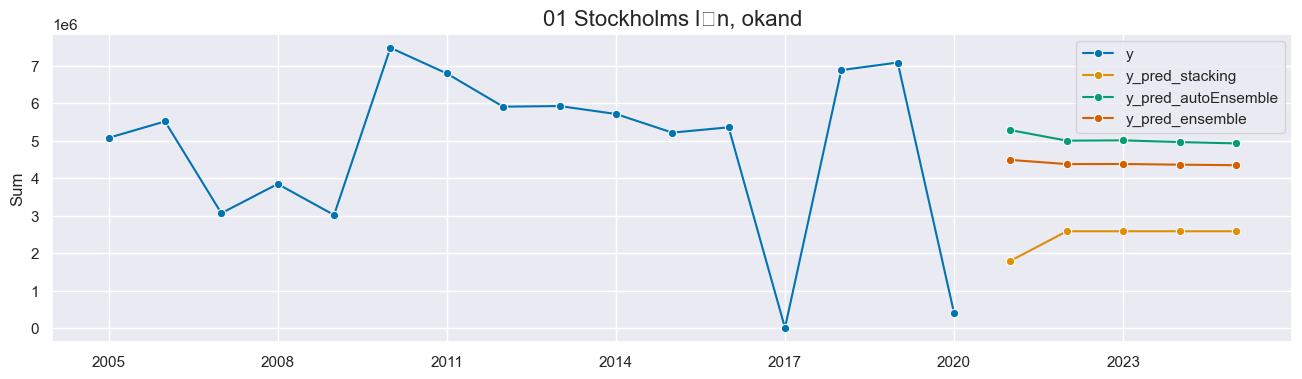

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


0117 �ster�ker
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\exponential_smoothing\ets.py:1161: RuntimeWarning: divide by zero encountered in log
  logL = -self.nobs / 2 * (np.log(2 * np.pi * np.mean(res ** 2)) + 1)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\scipy\optimize\_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\exponential_smoothing\ets.py:1161: RuntimeWarning: divide by zero encounte

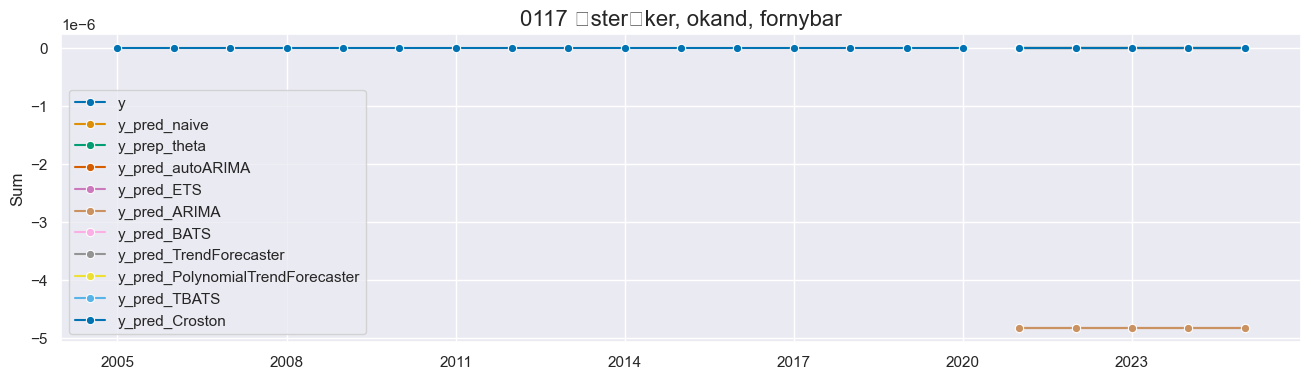

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\ProgramData\An

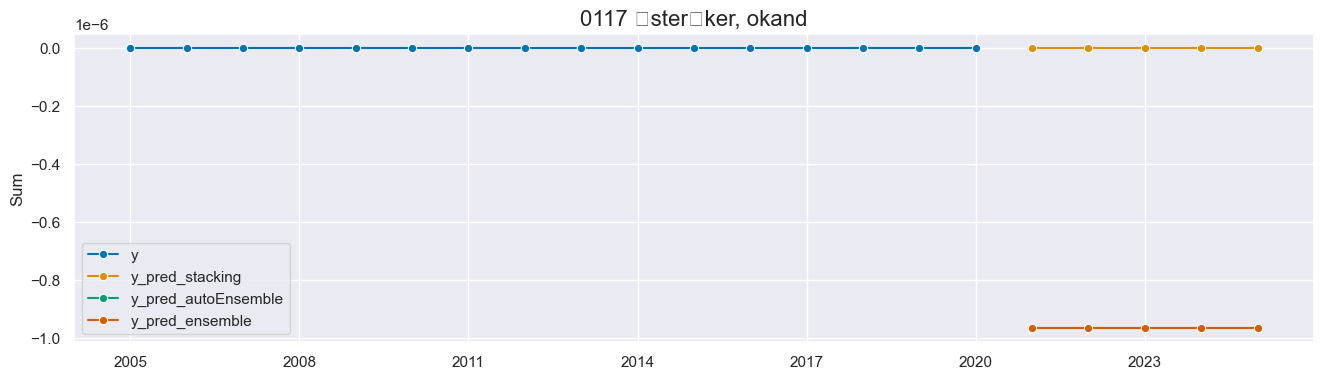

0160 T�by
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARM

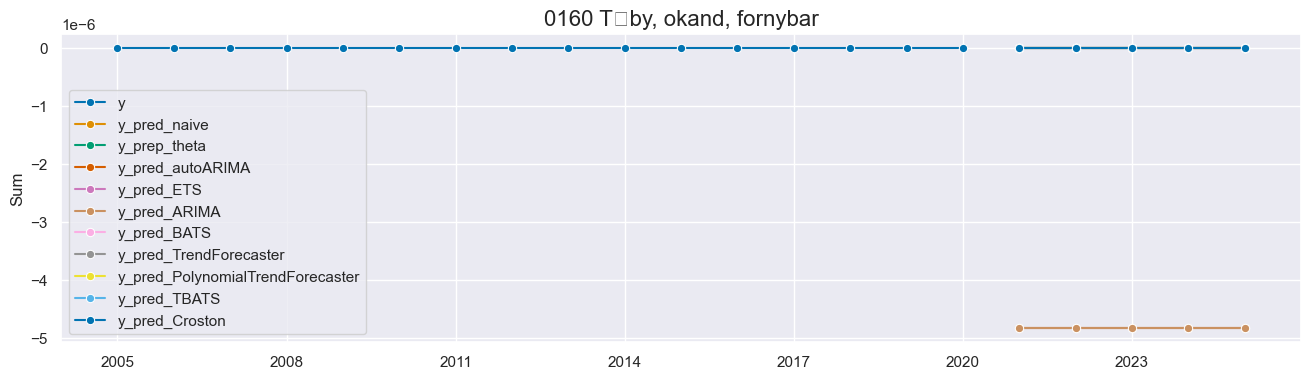

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1409: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1415: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
c:\ProgramData\An

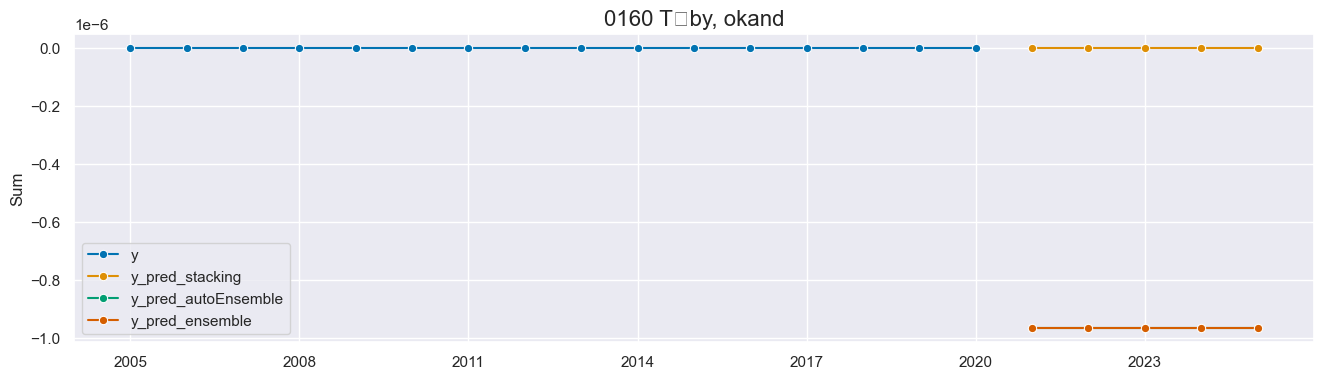

0180 Stockholm
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


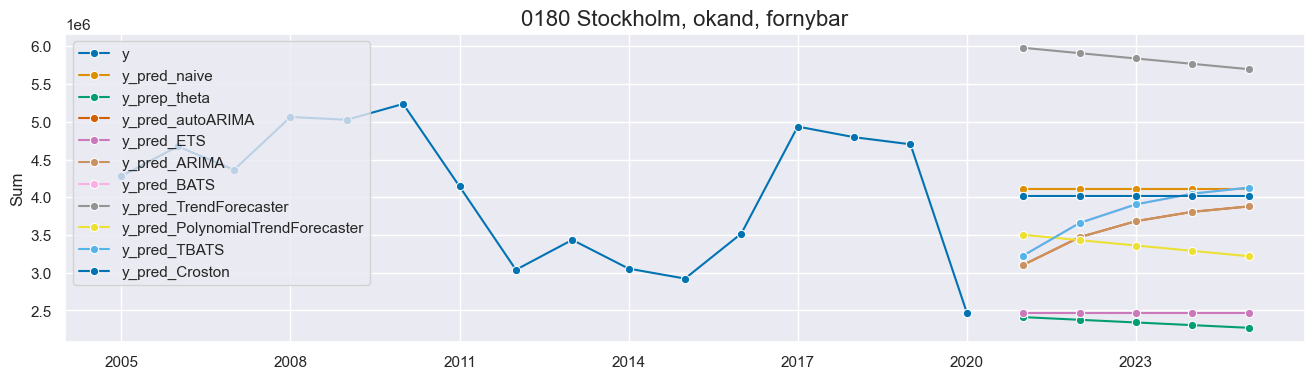

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

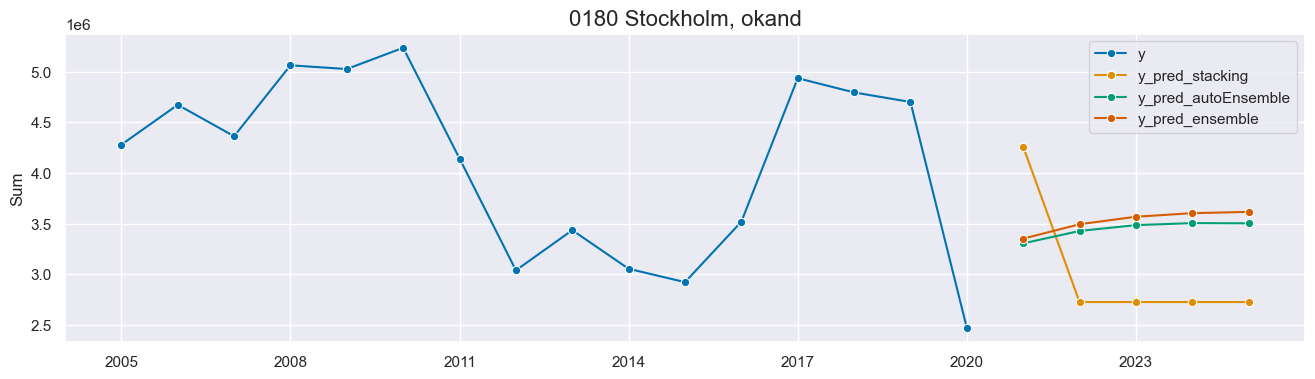

09 Gotlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


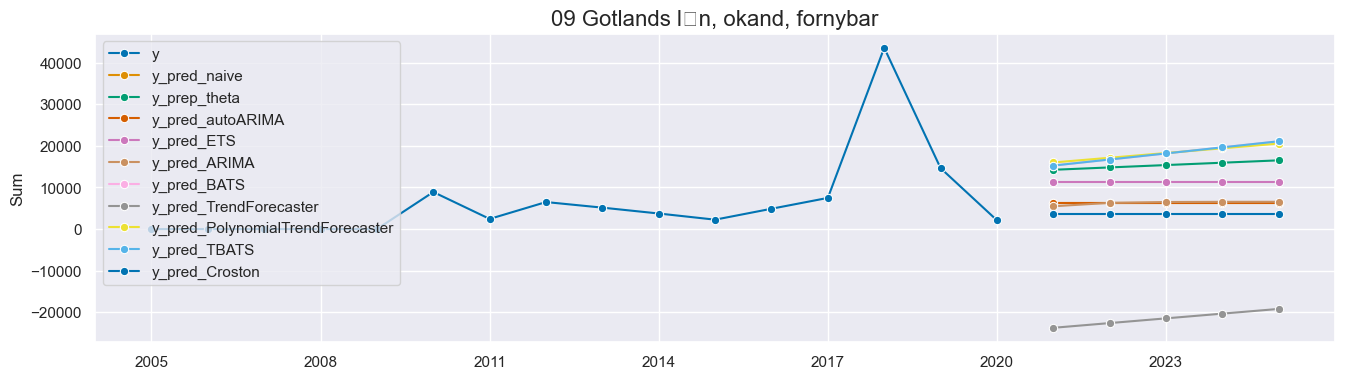

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thi

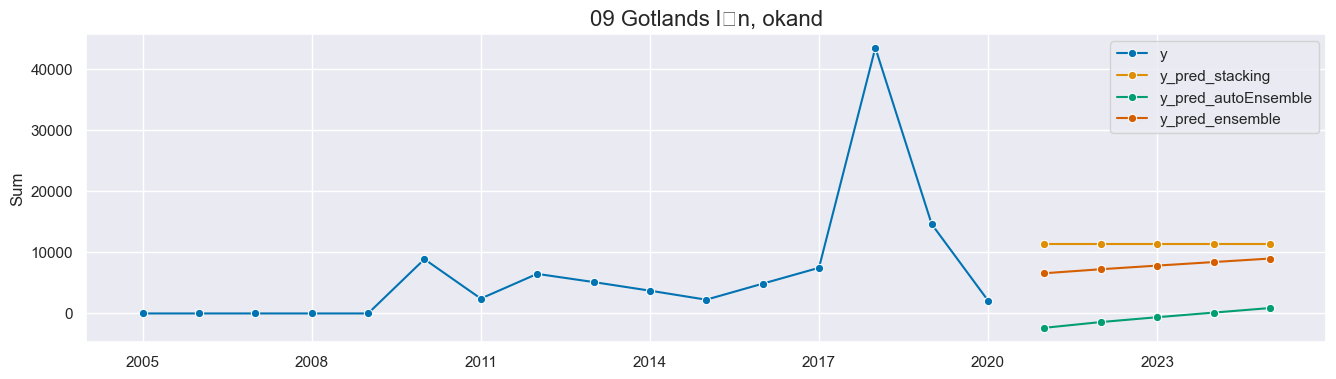

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0980 Gotland
okand
fornybar


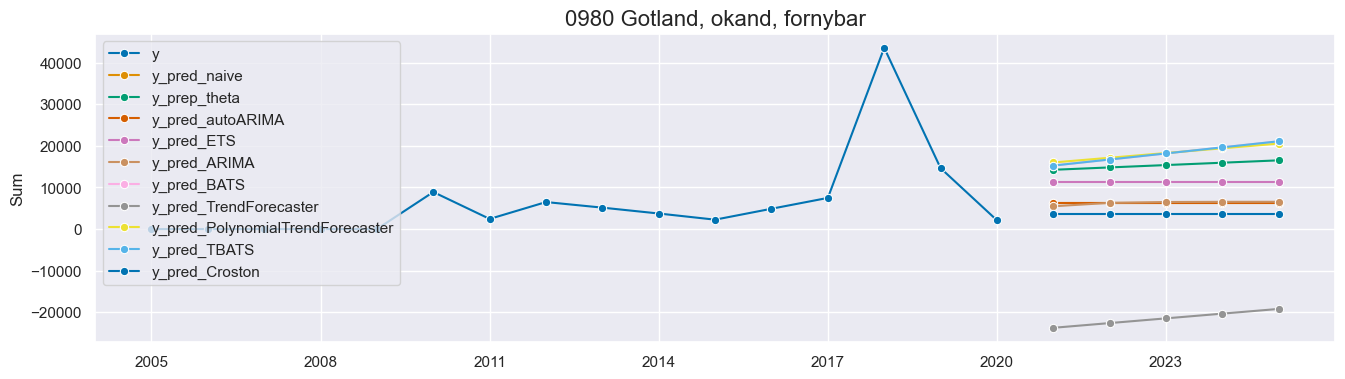

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thi

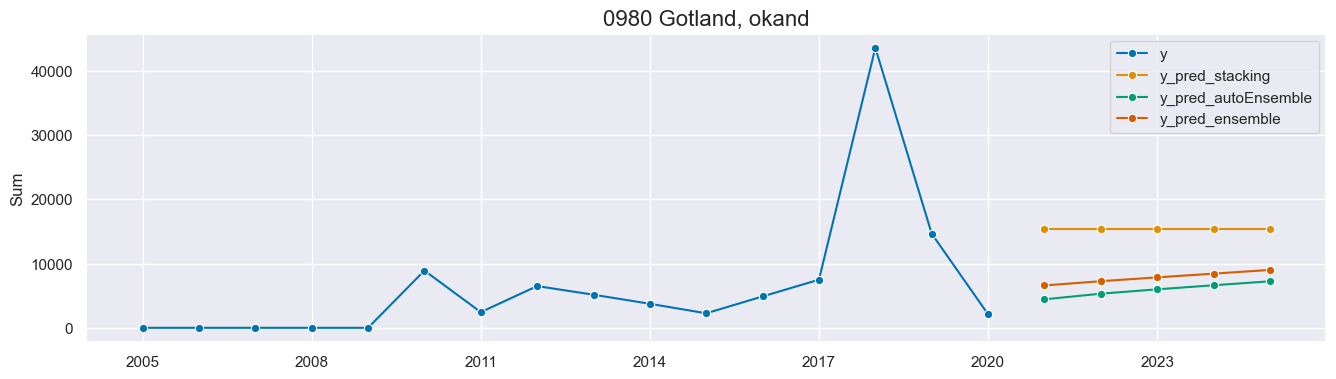

1480 G�teborg
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\s

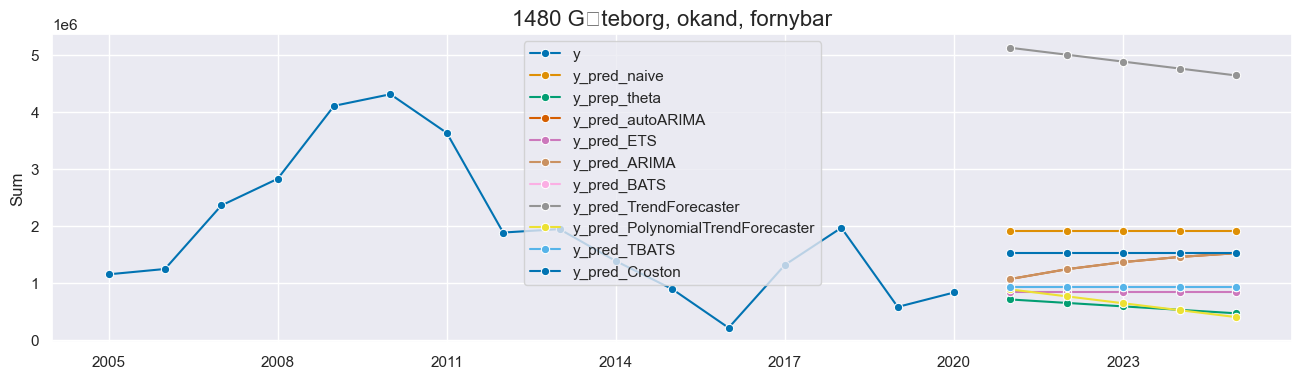

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

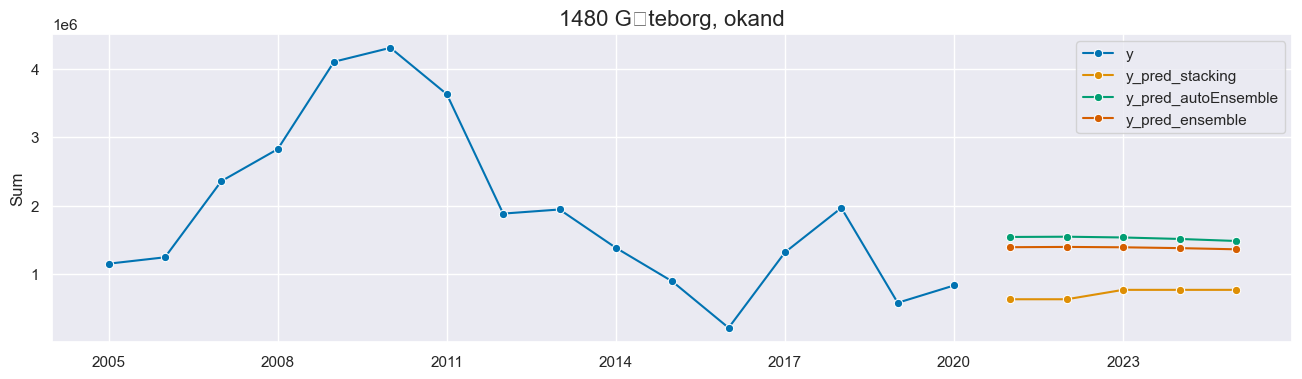

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


22 V�sternorrlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


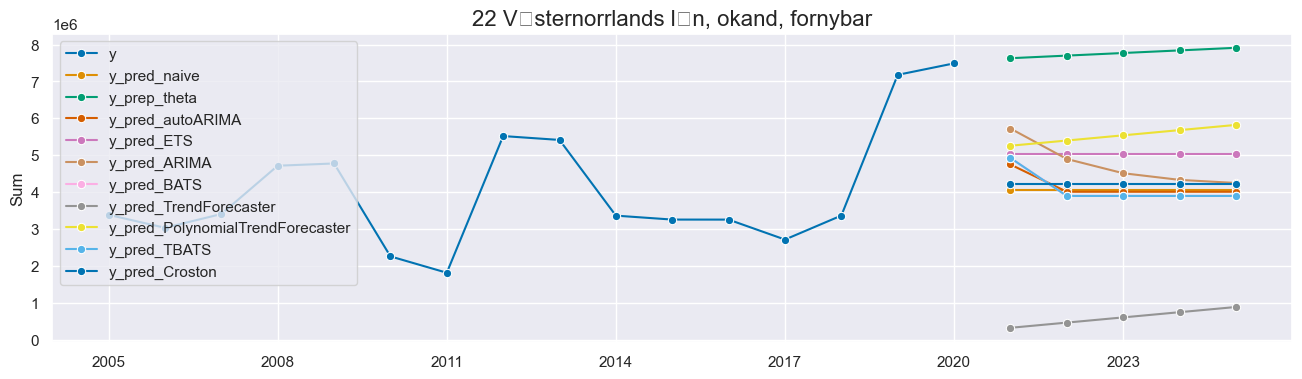

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,0,3)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Progra

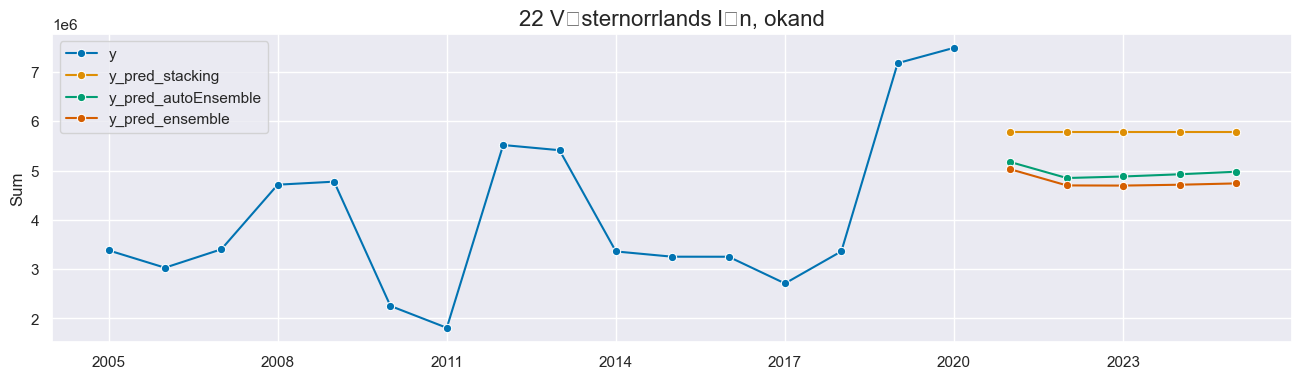

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


2581 Pite�
okand
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


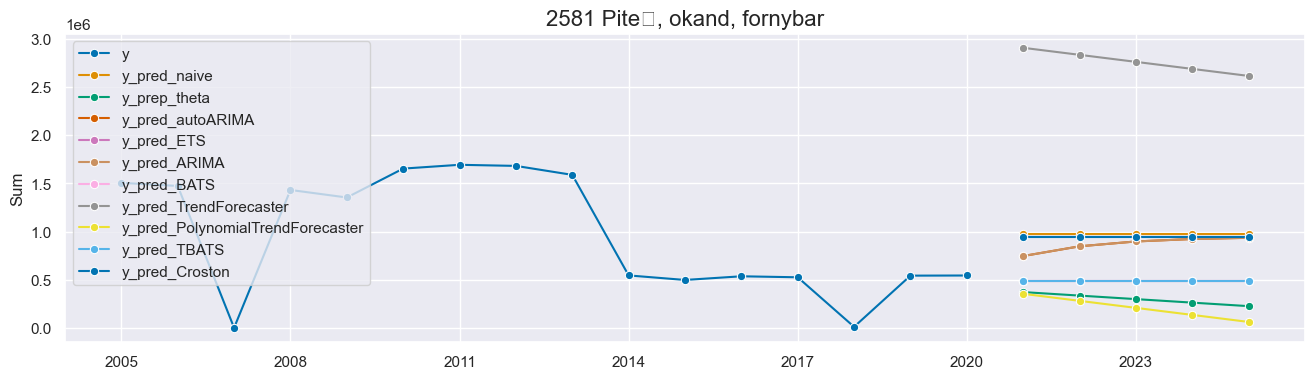

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

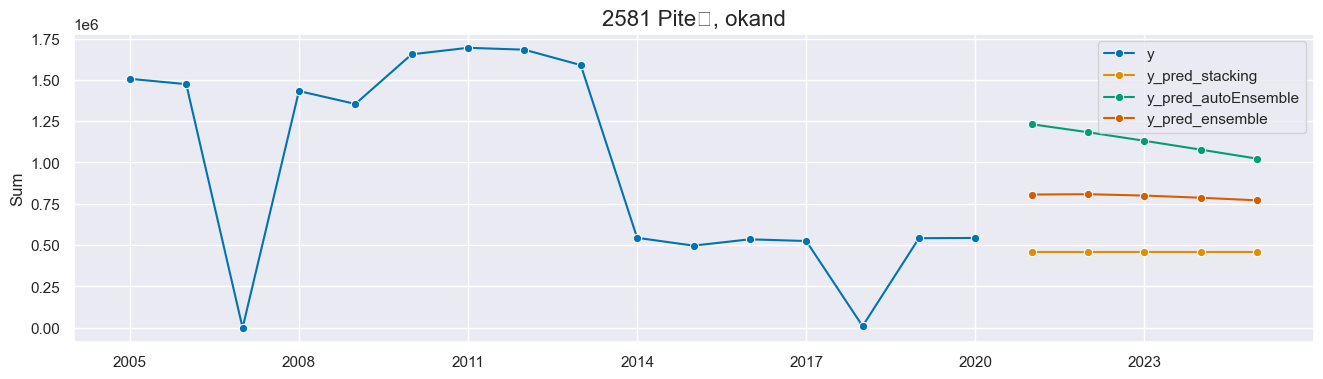

In [4]:
# elproduction_bransleanvandning_grouped
for region in elproduction_bransleanvandning_grouped.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = elproduction_bransleanvandning_grouped[elproduction_bransleanvandning_grouped.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(fornybar_produktionssatt)
                
                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS(seasonal=None).fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA(suppress_warnings=True).fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS(show_warnings=False).fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # Instantiate PolynomialTrendForecaster
                forecaster = PolynomialTrendForecaster().fit(y)
                # Predict PolynomialTrendForecaster 
                y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS(show_warnings=False).fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, 
                                    y_pred_theta, 
                                    y_pred_autoARIMA, 
                                    y_pred_ETS, 
                                    y_pred_ARIMA, 
                                    y_pred_BATS, 
                                    y_pred_TrendForecaster, 
                                    y_pred_PolynomialTrendForecaster, 
                                    y_pred_TBATS, 
                                    y_pred_Croston, 
                                    labels=["y", "y_pred_naive", 
                                        "y_prep_theta", 
                                        "y_pred_autoARIMA", 
                                        "y_pred_ETS", 
                                        "y_pred_ARIMA", 
                                        "y_pred_BATS", 
                                        "y_pred_TrendForecaster", 
                                        "y_pred_PolynomialTrendForecaster", 
                                        "y_pred_TBATS", 
                                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, fornybar_produktionssatt), fontsize=16)
                plt.show(fig)            
                
                forecasters = [
                    ("NaiveForecaster", NaiveForecaster()),
                    ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                    ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                    ("AutoETS", AutoETS(seasonal=None)),
                    ("ARIMA", ARIMA(suppress_warnings=True)),
                    ("BATS", BATS(show_warnings=False)),
                    ("TBATS", TBATS(show_warnings=False)),
                    ("TrendForecaster", TrendForecaster()),
                    ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                    ("Croston", Croston()),
                ]

                # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
                stackingForecaster = StackingForecaster(forecasters=forecasters)
                stackingForecaster.fit(y=y, fh=fh)
                y_pred_stacking = stackingForecaster.predict()

                # Automatically find best weights for the ensembled forecasters.
                autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
                autoEnsembleForecaster.fit(y=y)
                y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

                # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
                ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
                ensembleForecaster.fit(y=y)
                y_pred_ensemble = ensembleForecaster.predict(fh=fh)

                # Check it out:
                fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                    labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
                plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
                plt.show(fig)

                # print("----------------")   

            # else:
            #     print("----------------")   






00 Riket
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


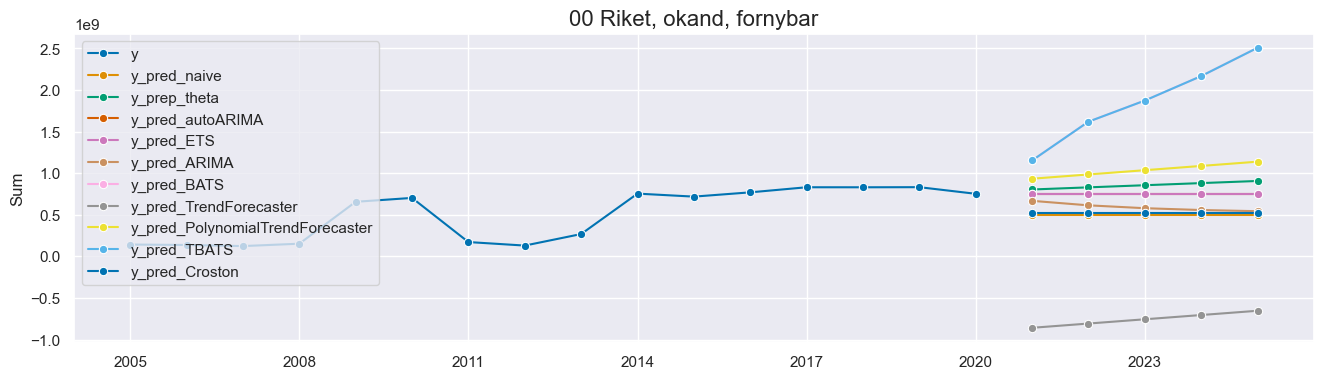

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

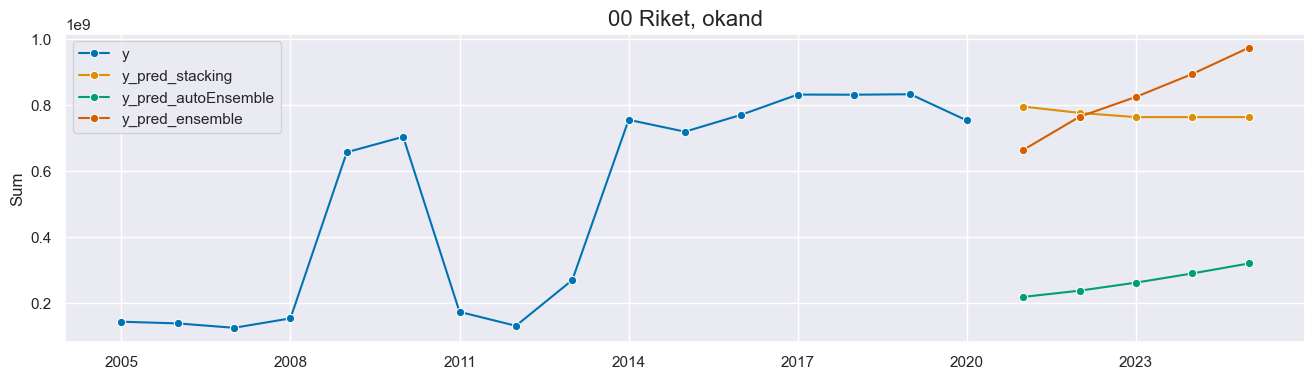

01 Stockholms l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


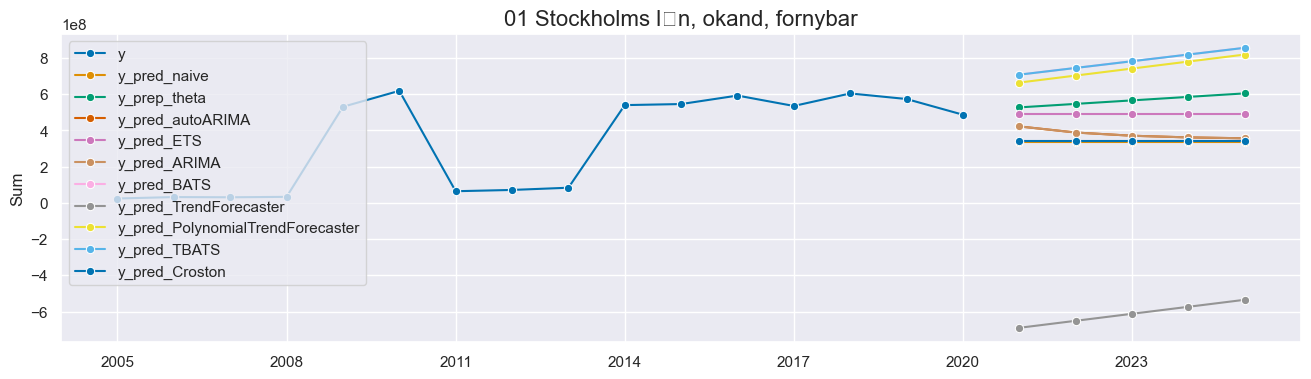

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

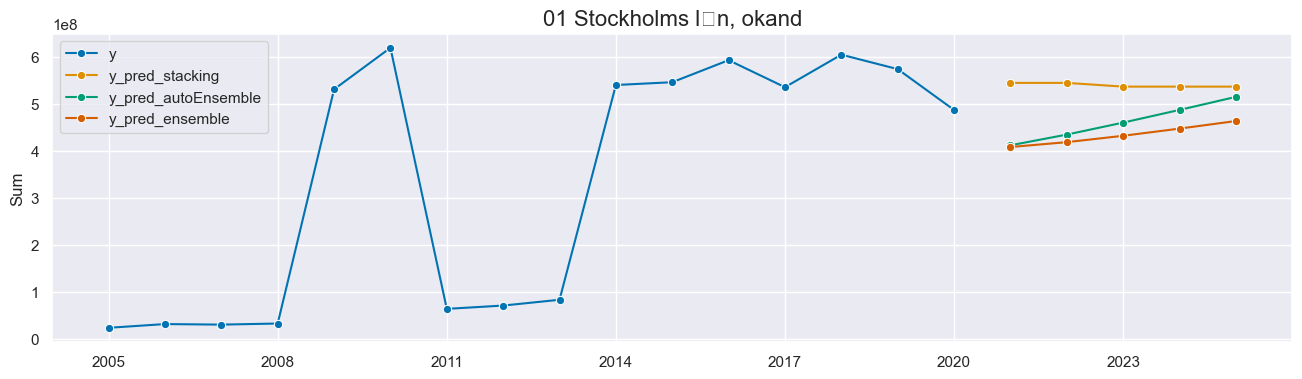

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0117 �ster�ker
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


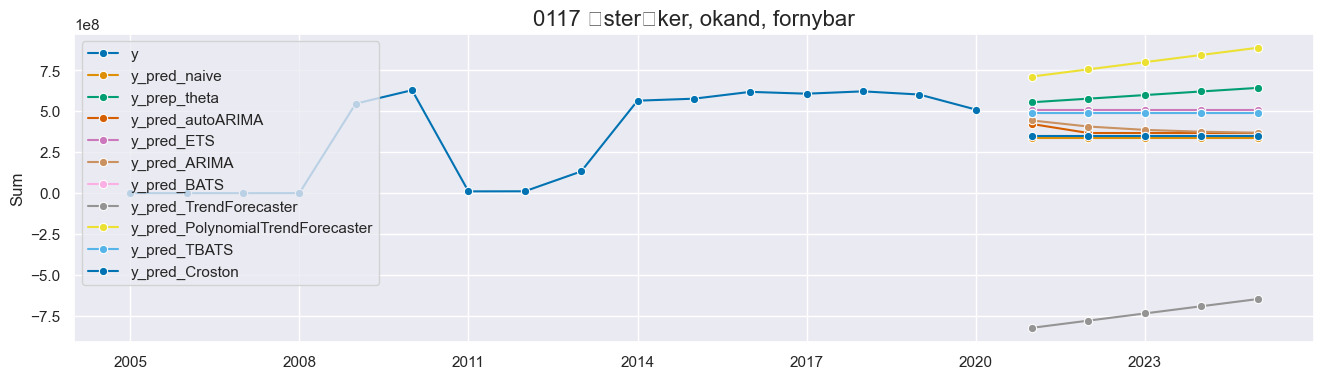

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

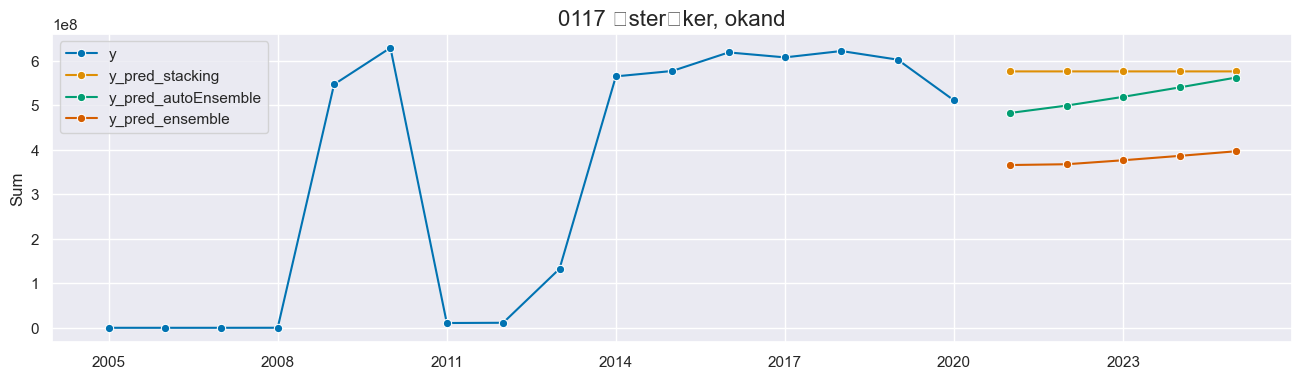

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0160 T�by
okand
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


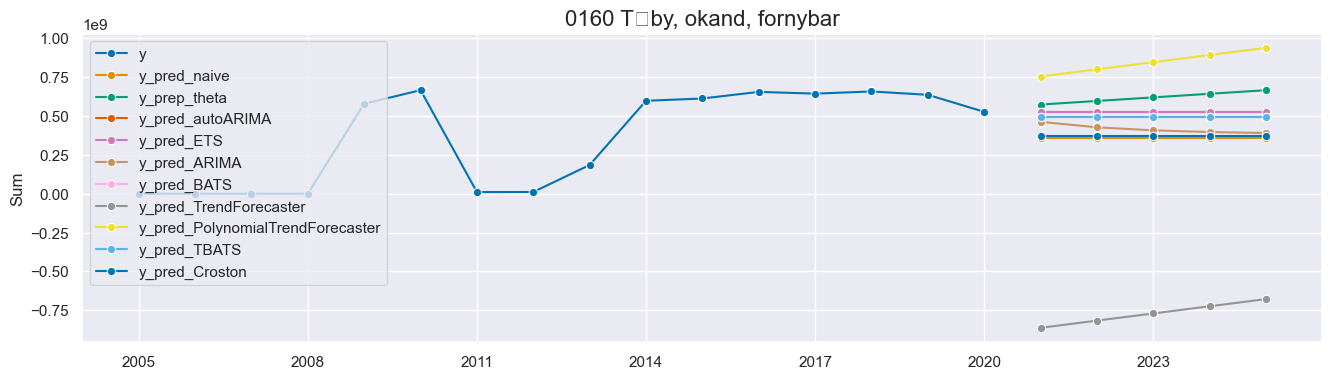

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

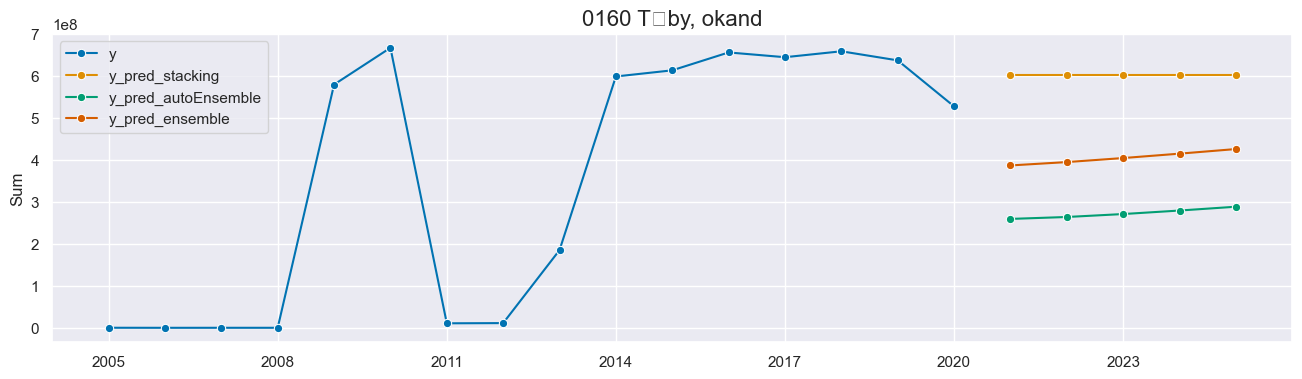

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0180 Stockholm
okand
fornybar


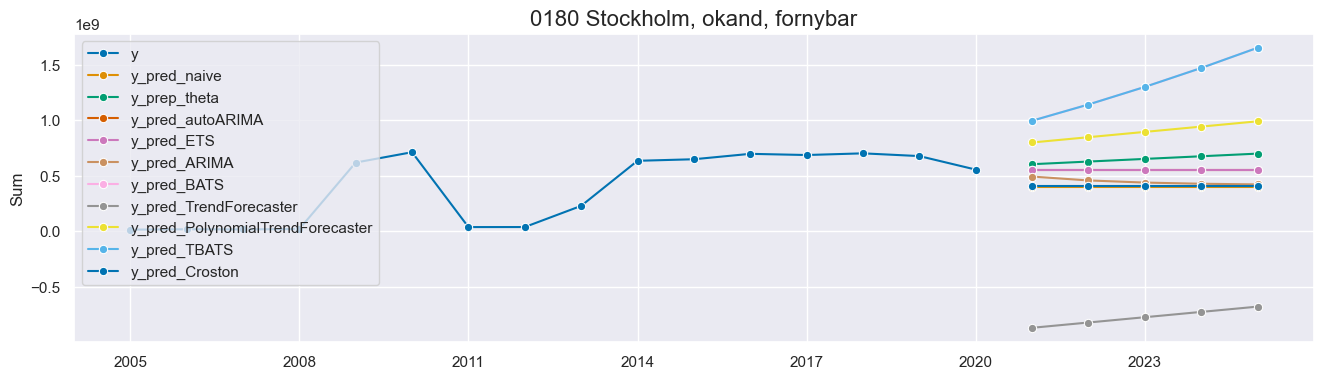

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

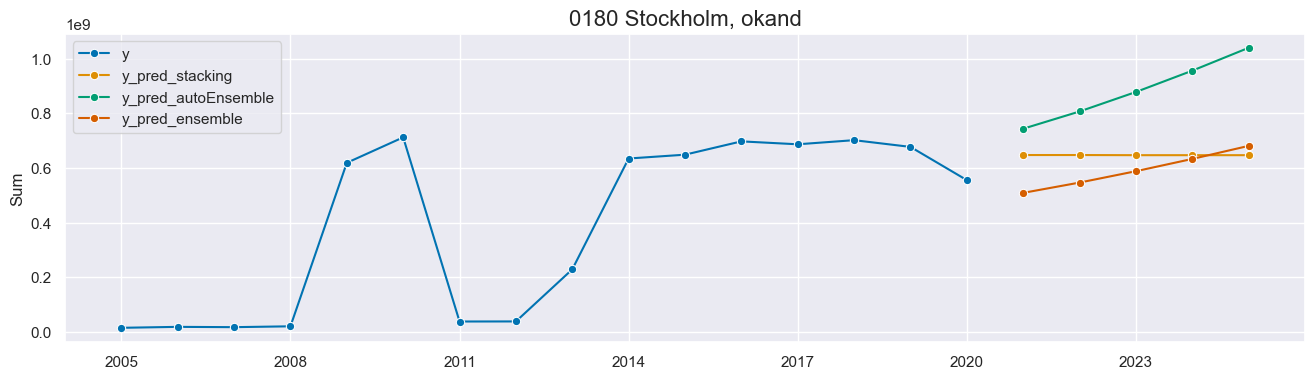

09 Gotlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


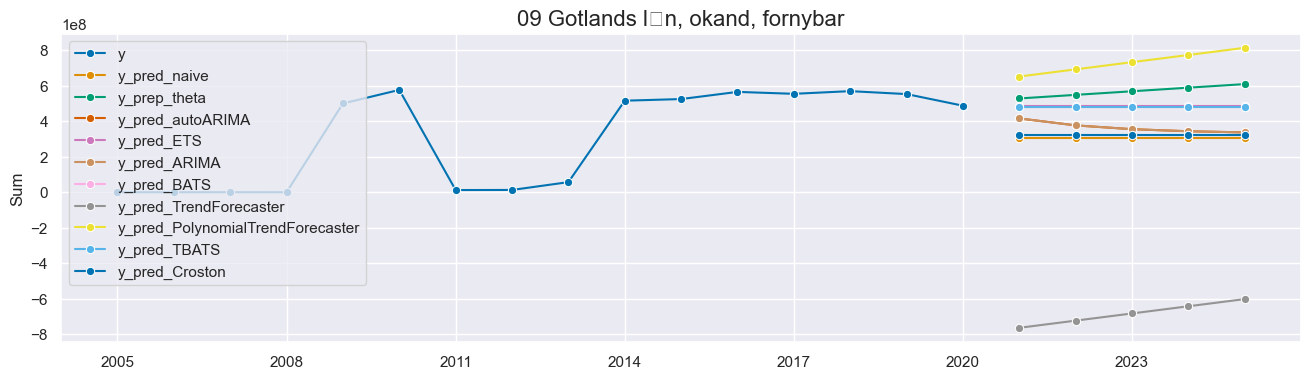

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

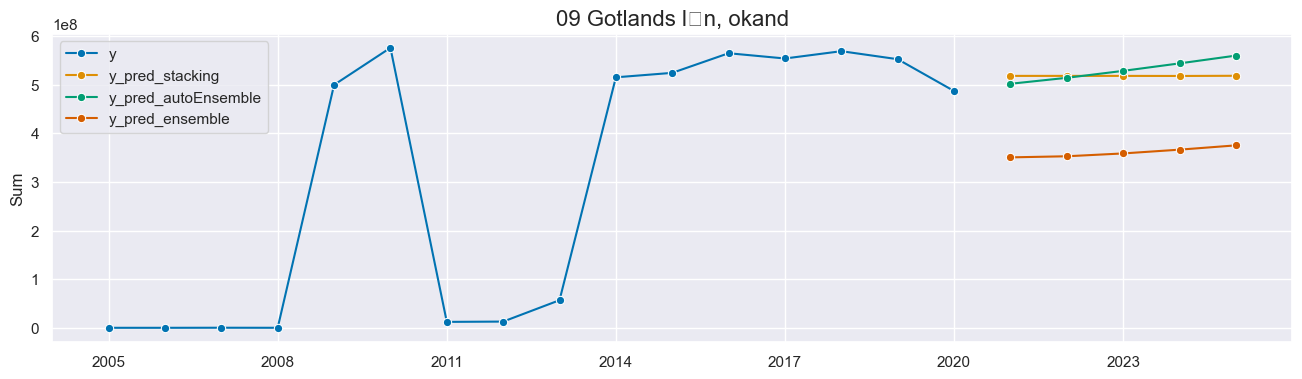

0980 Gotland
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


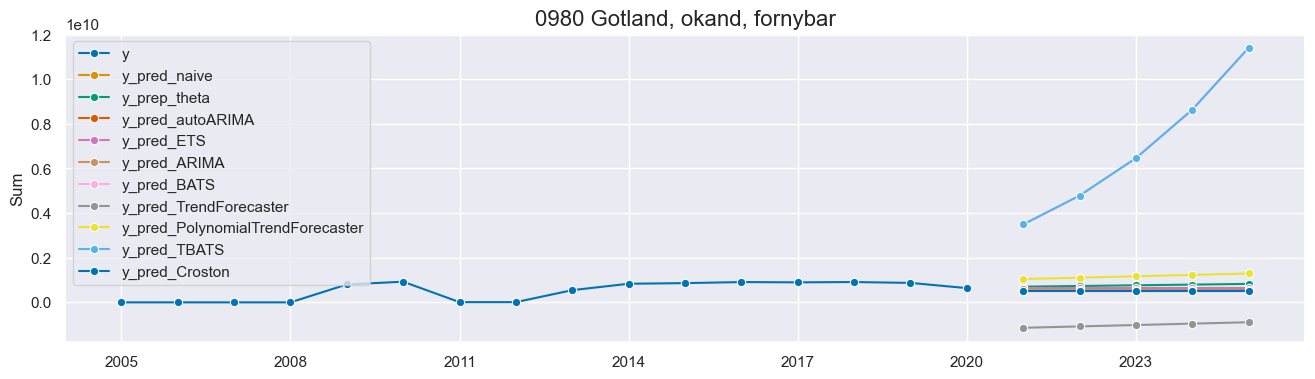

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

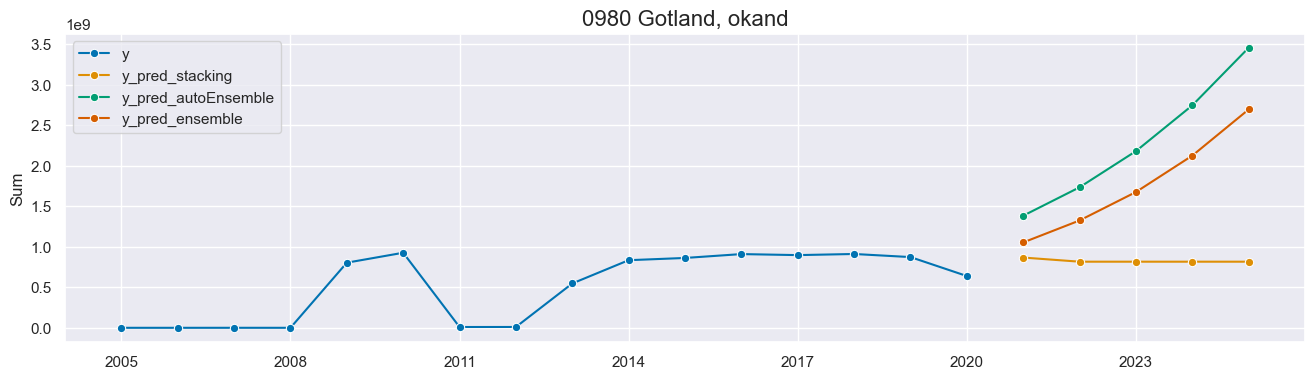

1480 G�teborg
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


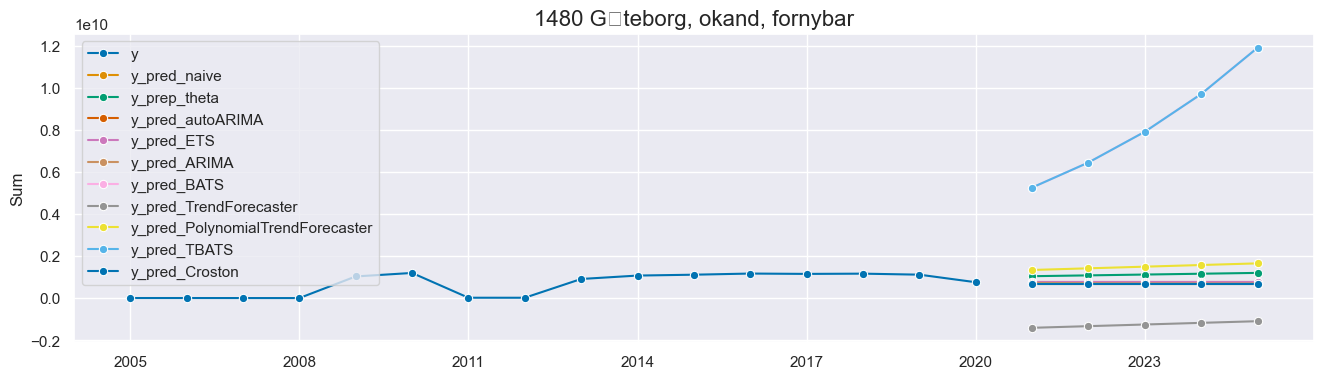

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

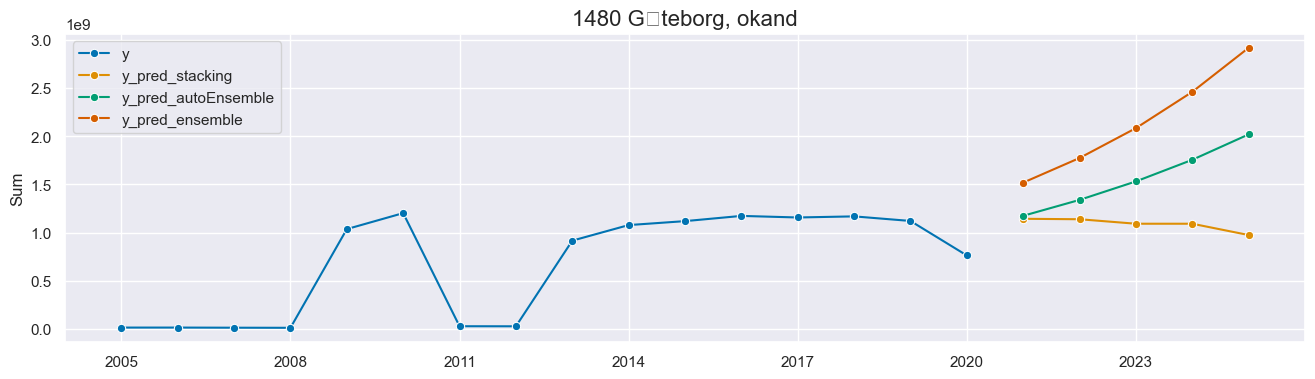

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


22 V�sternorrlands l�n
okand
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


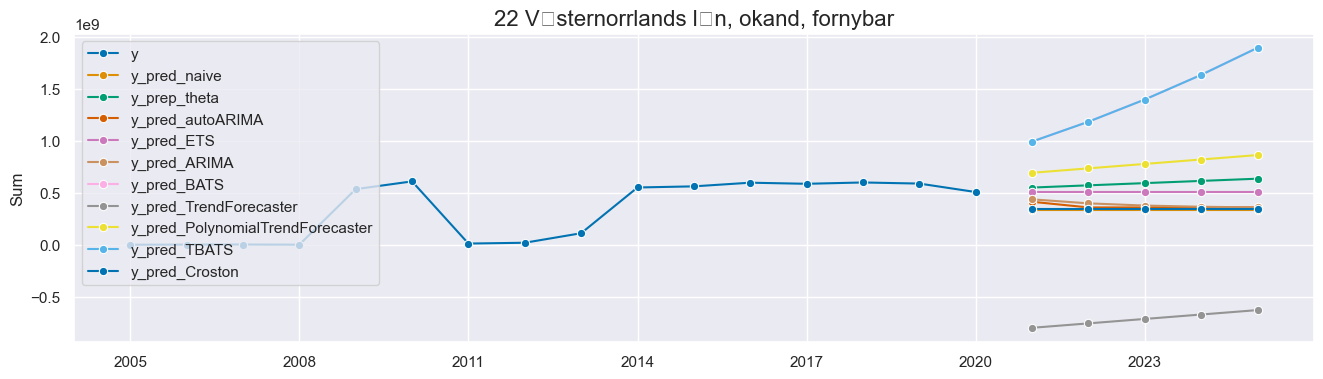

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

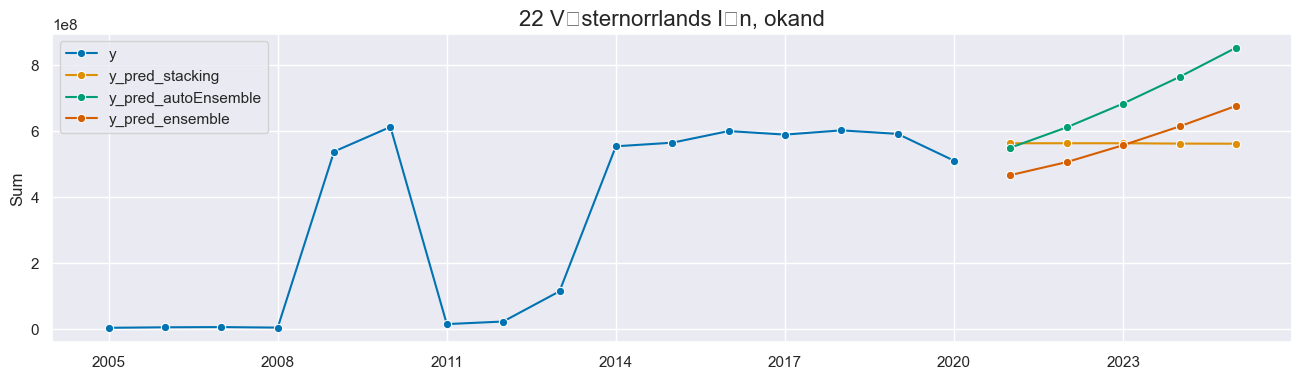

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


2581 Pite�
okand
fornybar


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


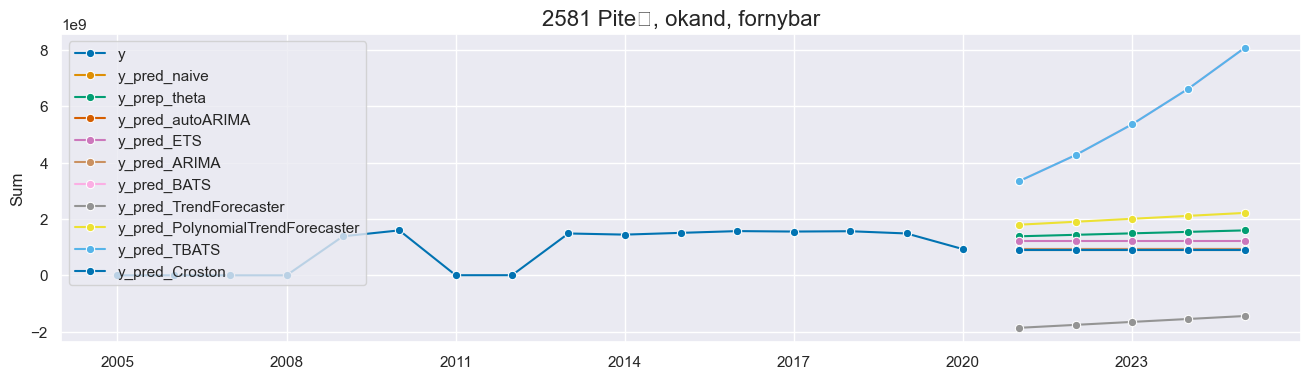

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

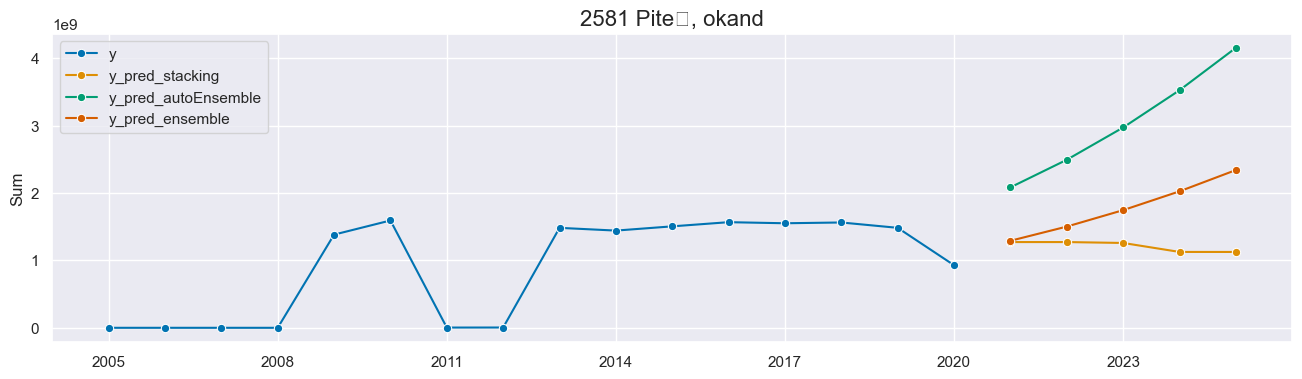

In [5]:
# fjarrvarmeproduktion
for region in fjarrvarmeproduktion.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = fjarrvarmeproduktion[fjarrvarmeproduktion.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for fornybar_produktionssatt in data.fornybar_produktionssatt.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_produktionssatt == fornybar_produktionssatt].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(fornybar_produktionssatt)
                
                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS(seasonal=None).fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA(suppress_warnings=True).fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS(show_warnings=False).fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # Instantiate PolynomialTrendForecaster
                forecaster = PolynomialTrendForecaster().fit(y)
                # Predict PolynomialTrendForecaster 
                y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS(show_warnings=False).fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, 
                                    y_pred_theta, 
                                    y_pred_autoARIMA, 
                                    y_pred_ETS, 
                                    y_pred_ARIMA, 
                                    y_pred_BATS, 
                                    y_pred_TrendForecaster, 
                                    y_pred_PolynomialTrendForecaster, 
                                    y_pred_TBATS, 
                                    y_pred_Croston, 
                                    labels=["y", "y_pred_naive", 
                                        "y_prep_theta", 
                                        "y_pred_autoARIMA", 
                                        "y_pred_ETS", 
                                        "y_pred_ARIMA", 
                                        "y_pred_BATS", 
                                        "y_pred_TrendForecaster", 
                                        "y_pred_PolynomialTrendForecaster", 
                                        "y_pred_TBATS", 
                                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, fornybar_produktionssatt), fontsize=16)
                plt.show(fig)            
                
                forecasters = [
                    ("NaiveForecaster", NaiveForecaster()),
                    ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                    ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                    ("AutoETS", AutoETS(seasonal=None)),
                    ("ARIMA", ARIMA(suppress_warnings=True)),
                    ("BATS", BATS(show_warnings=False)),
                    ("TBATS", TBATS(show_warnings=False)),
                    ("TrendForecaster", TrendForecaster()),
                    ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                    ("Croston", Croston()),
                ]

                # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
                stackingForecaster = StackingForecaster(forecasters=forecasters)
                stackingForecaster.fit(y=y, fh=fh)
                y_pred_stacking = stackingForecaster.predict()

                # Automatically find best weights for the ensembled forecasters.
                autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
                autoEnsembleForecaster.fit(y=y)
                y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

                # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
                ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
                ensembleForecaster.fit(y=y)
                y_pred_ensemble = ensembleForecaster.predict(fh=fh)

                # Check it out:
                fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                    labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
                plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
                plt.show(fig)



                # print("----------------")   

            # else:
            #     print("----------------")   


00 Riket
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


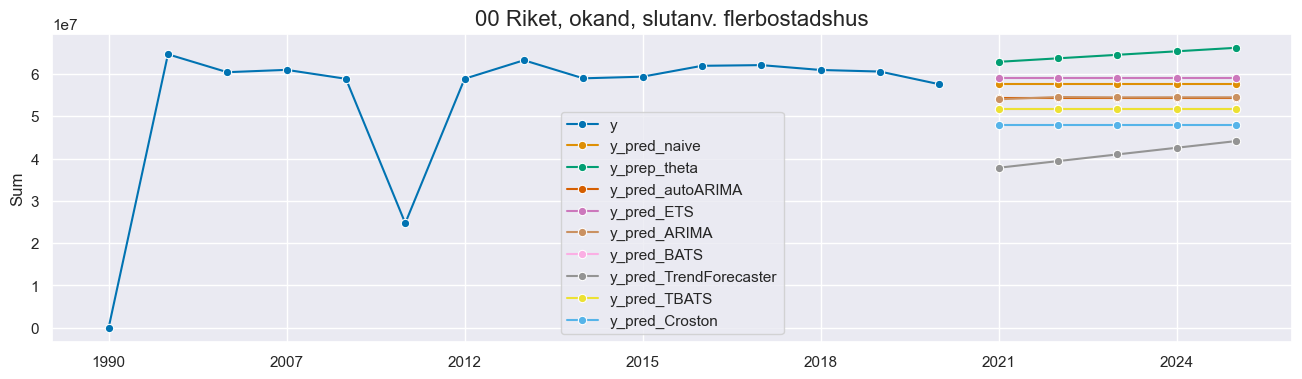

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

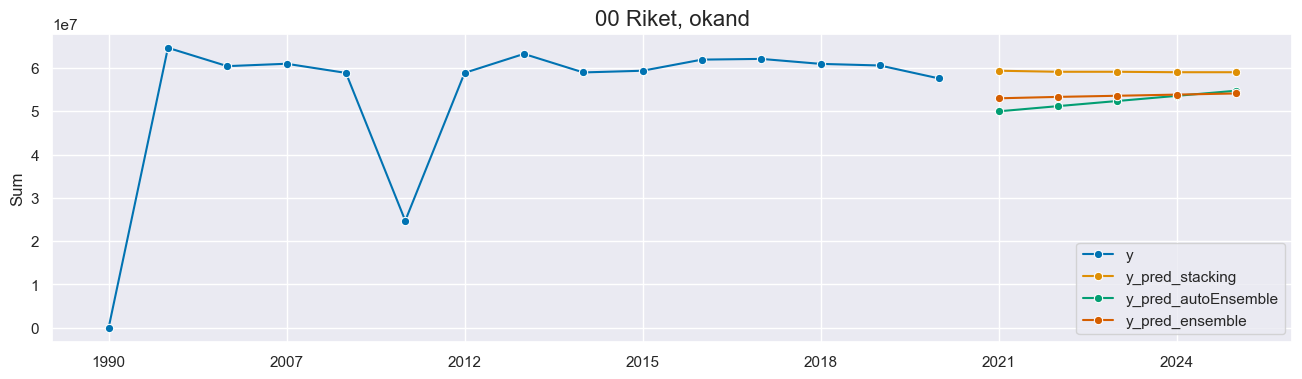

01 Stockholms l�n
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anacon

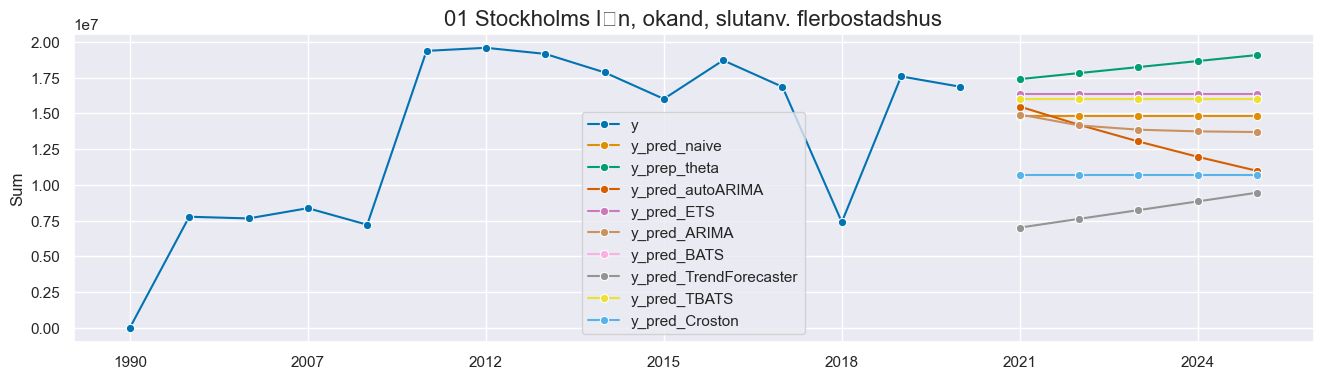

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

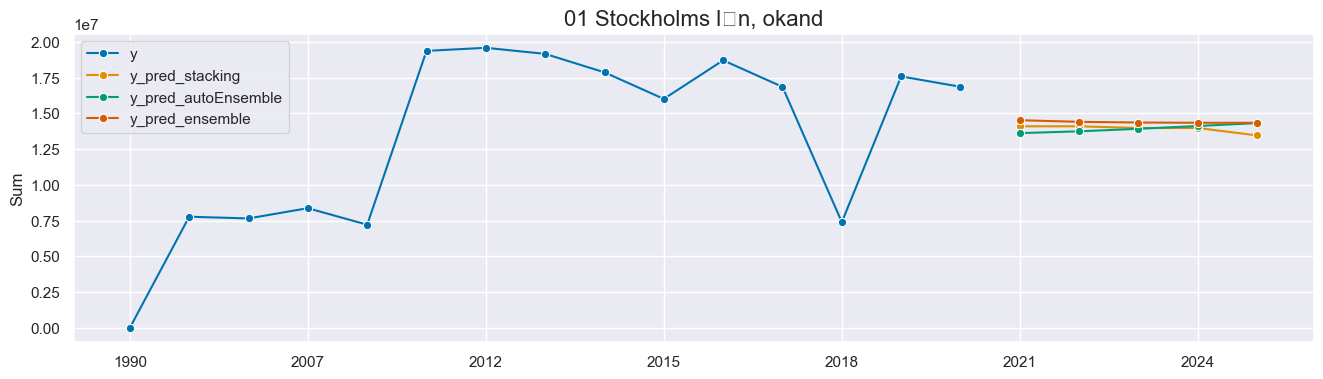

0117 �ster�ker
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


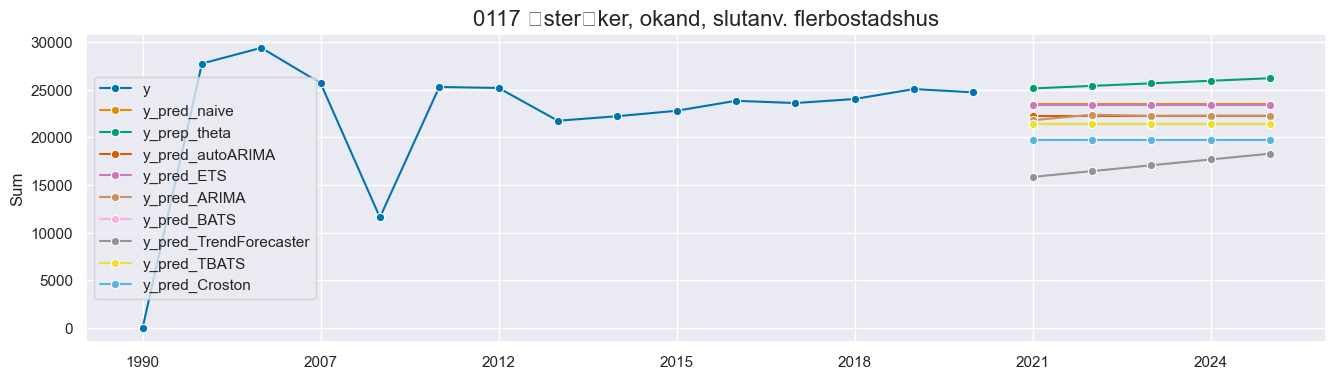

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

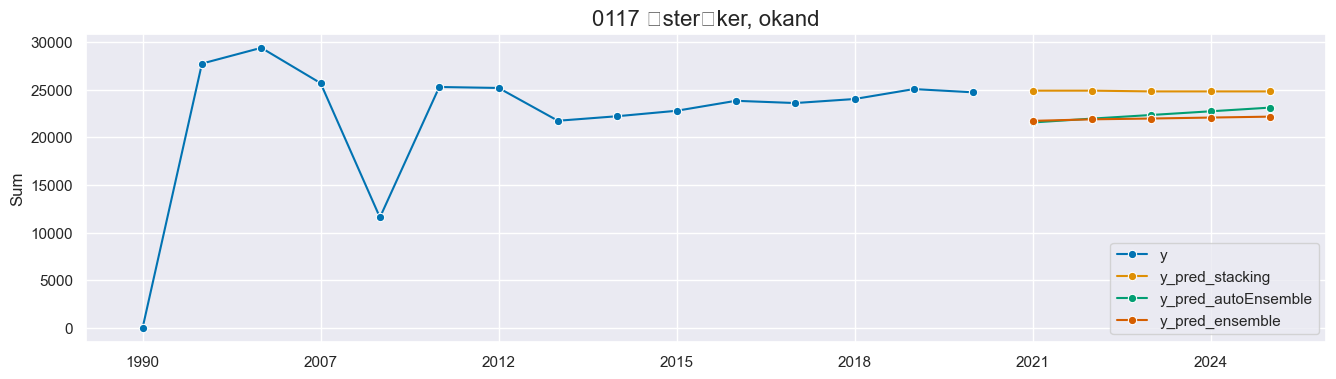

0160 T�by
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


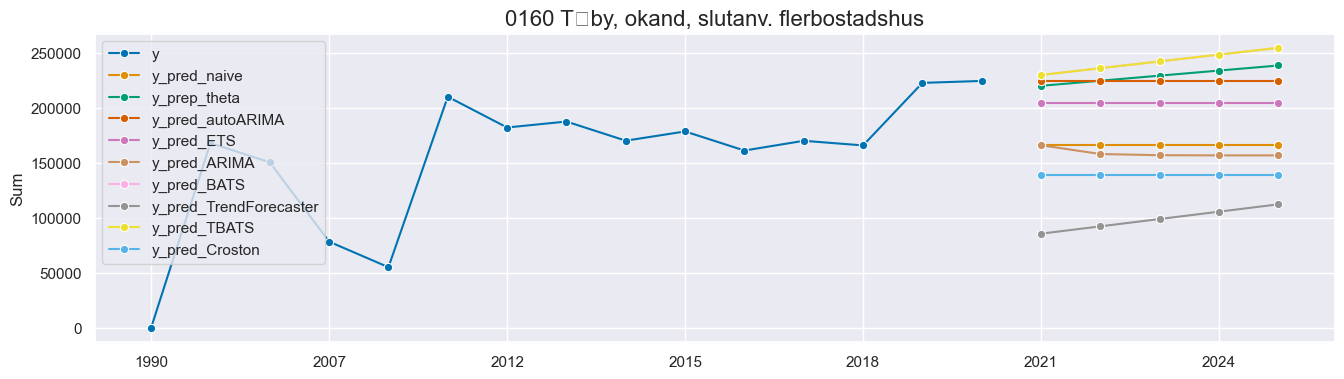

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

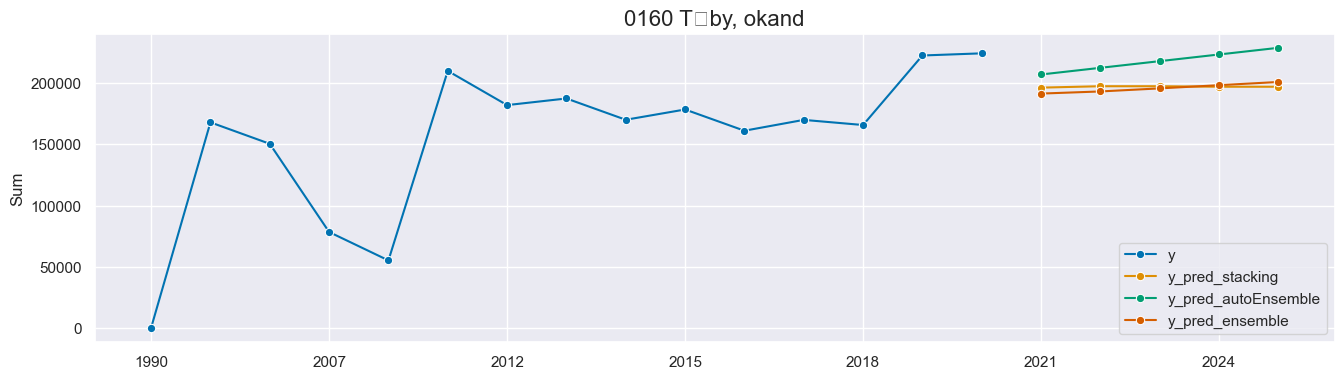

0180 Stockholm
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


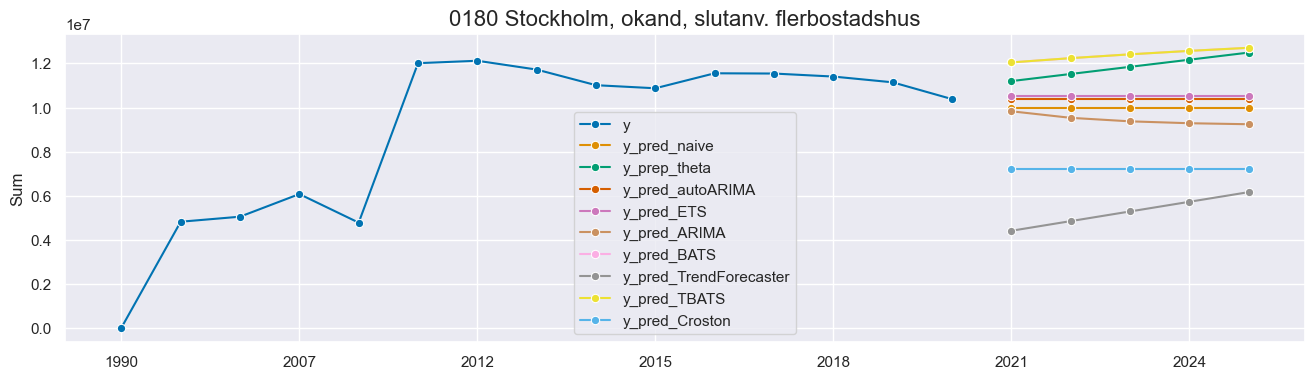

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

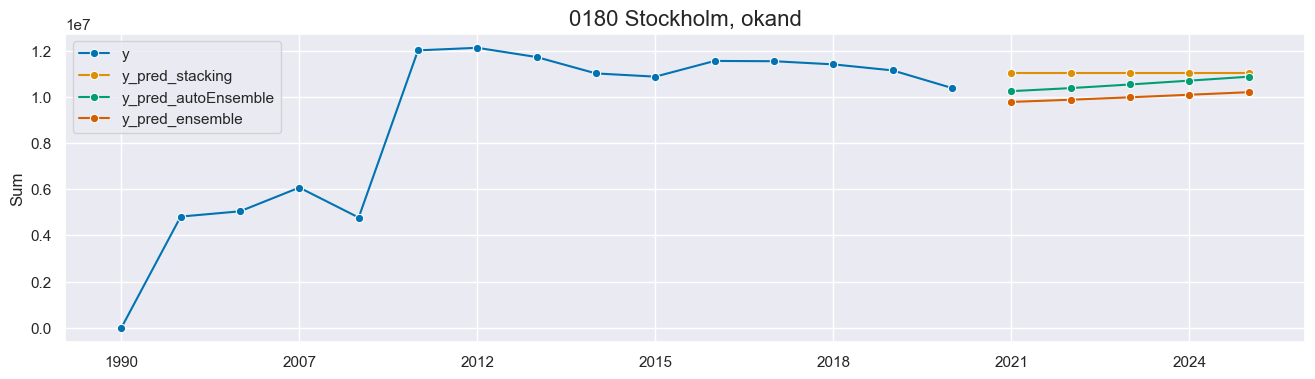

09 Gotlands l�n
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


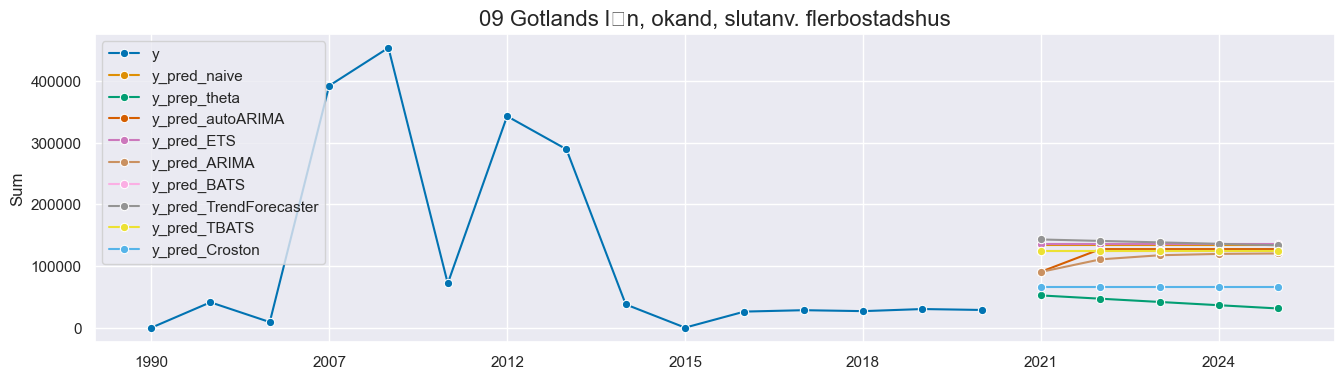

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

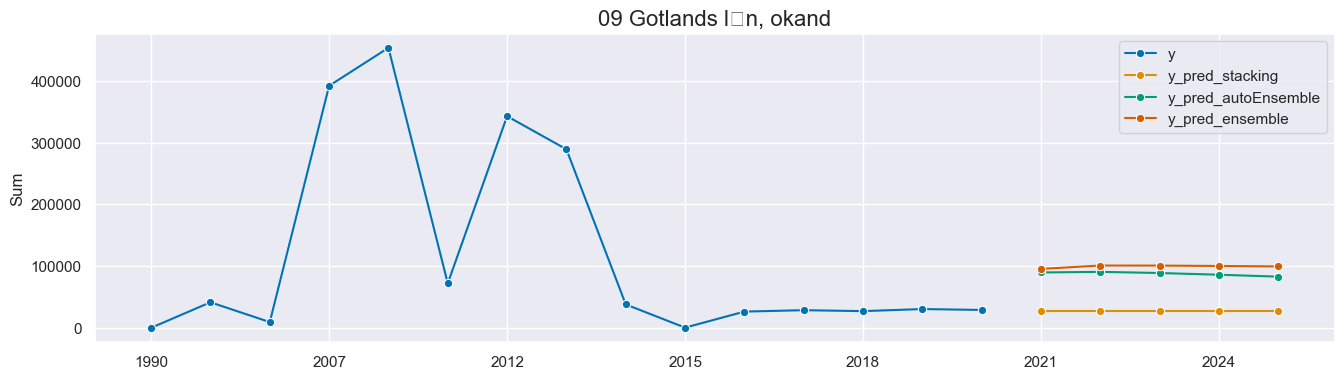

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0980 Gotland
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


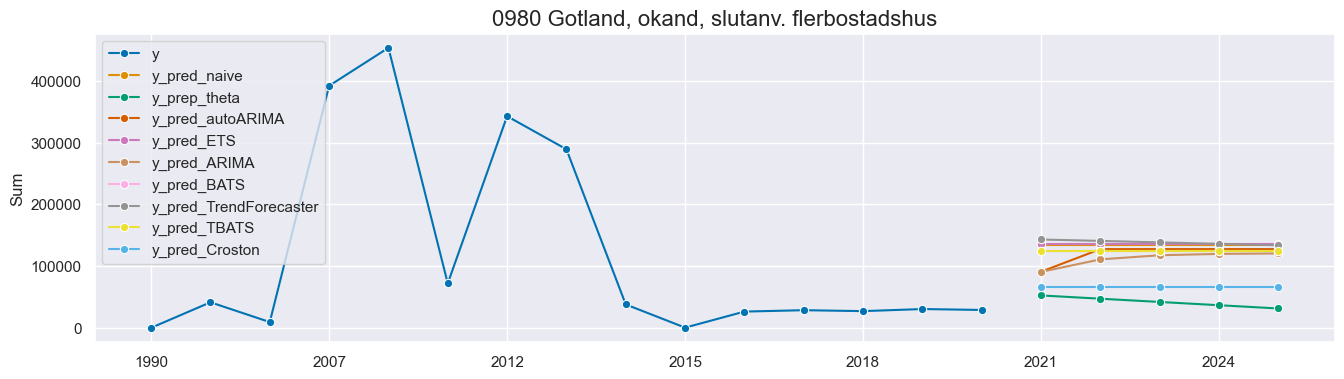

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

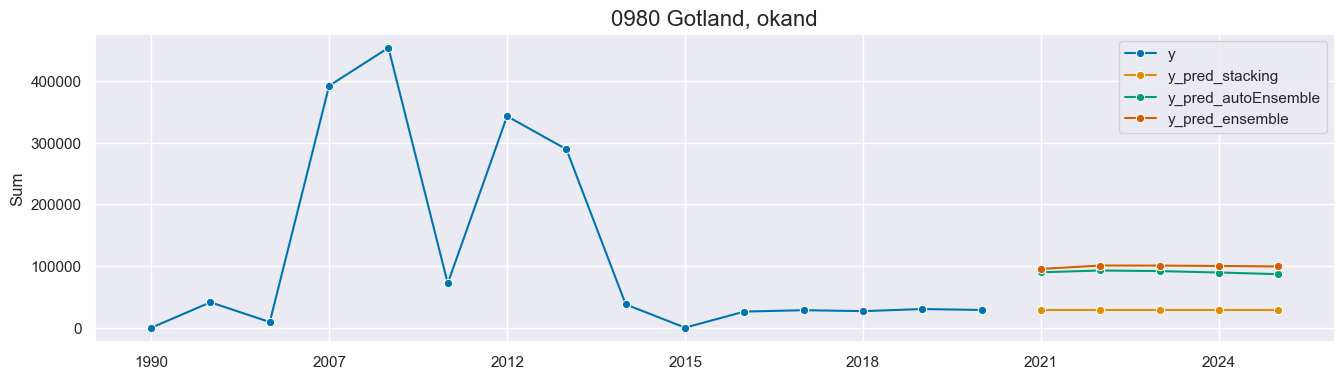

1480 G�teborg
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\s

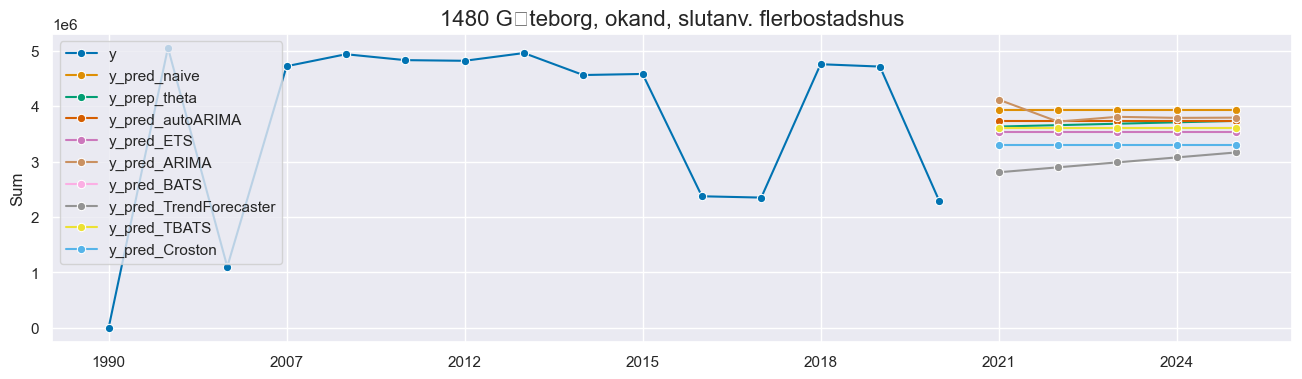

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

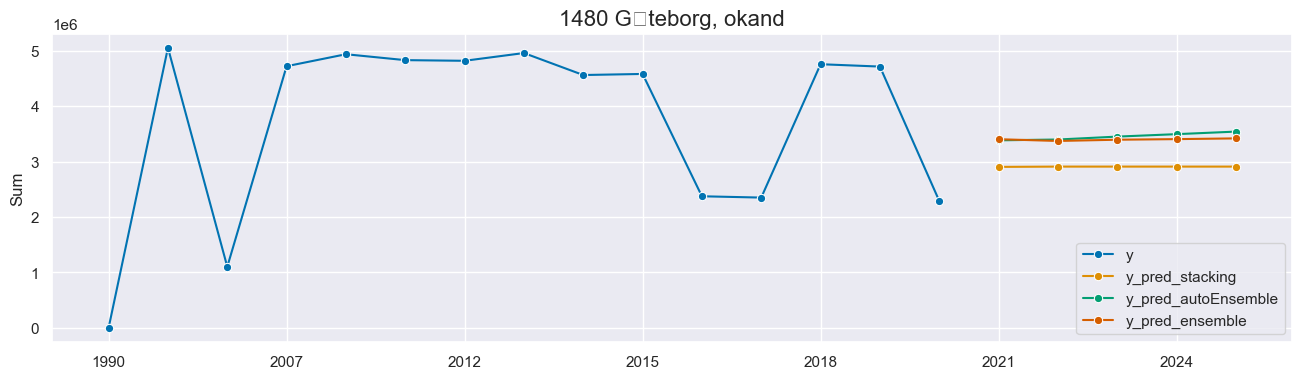

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


22 V�sternorrlands l�n
okand
slutanv. flerbostadshus


C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


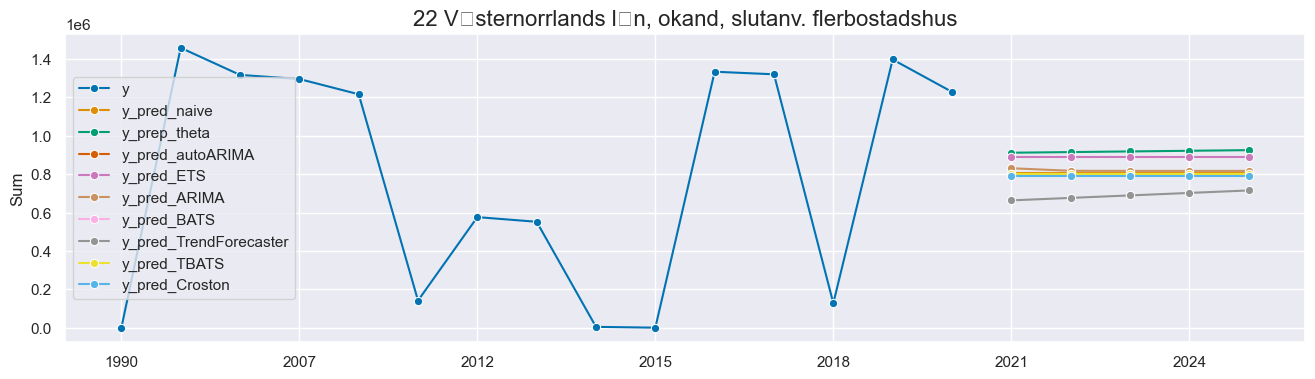

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

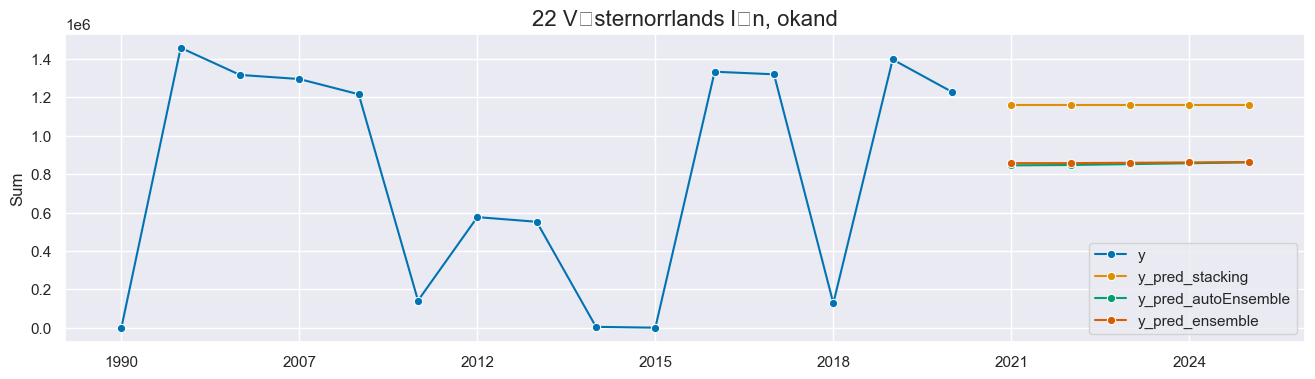

2581 Pite�
okand
slutanv. flerbostadshus


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\s

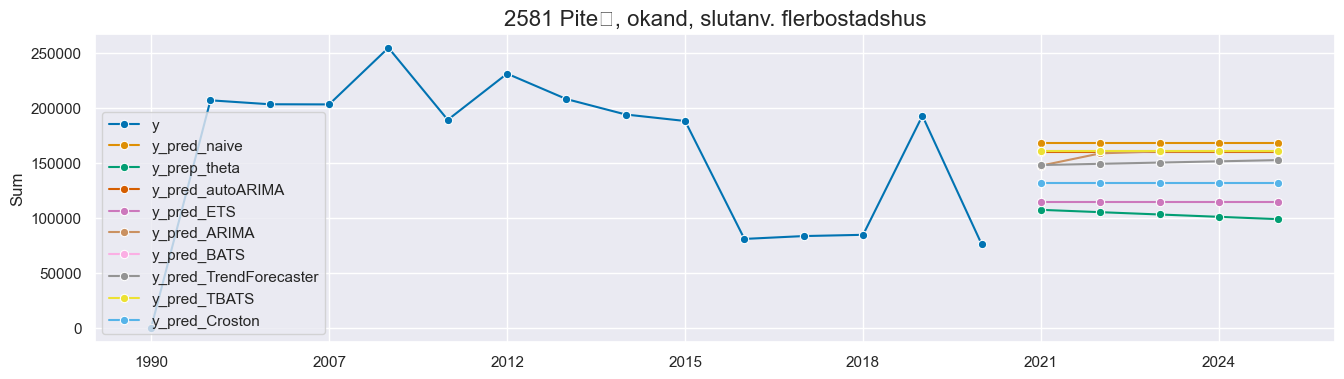

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thi

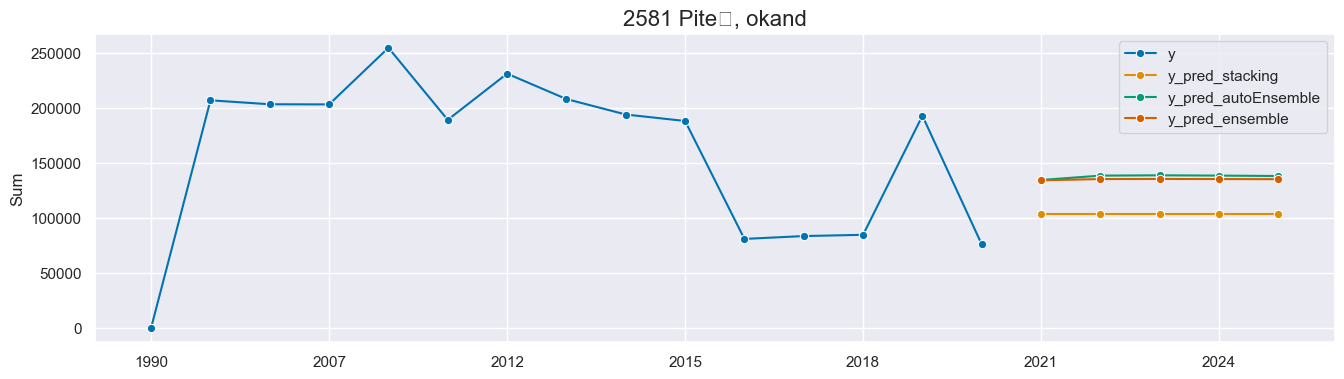

In [6]:
# slutanvandning
for region in slutanvandning.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = slutanvandning[slutanvandning.region == region].reset_index(drop=True)    
    for fornybar_bransletyp in data.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)
        for forbrukarkategori in data.forbrukarkategori.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.forbrukarkategori == forbrukarkategori].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_bransletyp)
                print(forbrukarkategori)

                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS(seasonal=None).fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA(suppress_warnings=True).fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS(show_warnings=False).fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # # Instantiate PolynomialTrendForecaster
                # forecaster = PolynomialTrendForecaster().fit(y)
                # # Predict PolynomialTrendForecaster 
                # y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS(show_warnings=False).fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred,
                        y_pred_theta, 
                        y_pred_autoARIMA, 
                        y_pred_ETS, 
                        y_pred_ARIMA, 
                        y_pred_BATS, 
                        y_pred_TrendForecaster, 
                        # y_pred_PolynomialTrendForecaster, 
                        y_pred_TBATS, 
                        y_pred_Croston, 
                        labels=["y", "y_pred_naive", 
                        "y_prep_theta", 
                        "y_pred_autoARIMA", 
                        "y_pred_ETS", 
                        "y_pred_ARIMA", 
                        "y_pred_BATS", 
                        "y_pred_TrendForecaster", 
                        # "y_pred_PolynomialTrendForecaster", 
                        "y_pred_TBATS", 
                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_bransletyp, forbrukarkategori), fontsize=16)
                plt.show(fig)            
                

                forecasters = [
                    ("NaiveForecaster", NaiveForecaster()),
                    ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                    ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                    ("AutoETS", AutoETS(seasonal=None)),
                    ("ARIMA", ARIMA(suppress_warnings=True)),
                    ("BATS", BATS(show_warnings=False)),
                    ("TBATS", TBATS(show_warnings=False)),
                    ("TrendForecaster", TrendForecaster()),
                    # ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                    ("Croston", Croston()),
                ]

                # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
                stackingForecaster = StackingForecaster(forecasters=forecasters)
                stackingForecaster.fit(y=y, fh=fh)
                y_pred_stacking = stackingForecaster.predict()

                # Automatically find best weights for the ensembled forecasters.
                autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
                autoEnsembleForecaster.fit(y=y)
                y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

                # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
                ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
                ensembleForecaster.fit(y=y)
                y_pred_ensemble = ensembleForecaster.predict(fh=fh)

                # Check it out:
                fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                    labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
                plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
                plt.show(fig)

                # print("----------------")   

            # else:
            #     print("----------------")   


fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


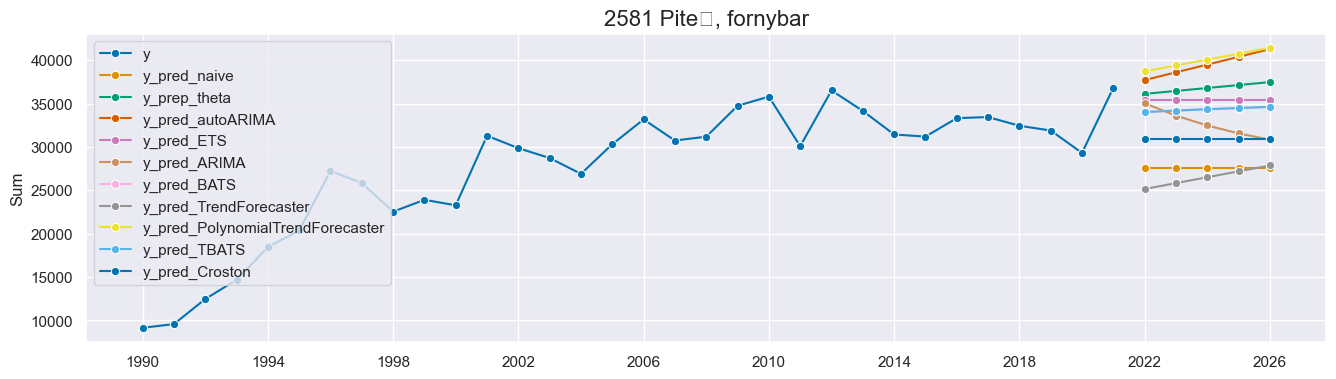

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


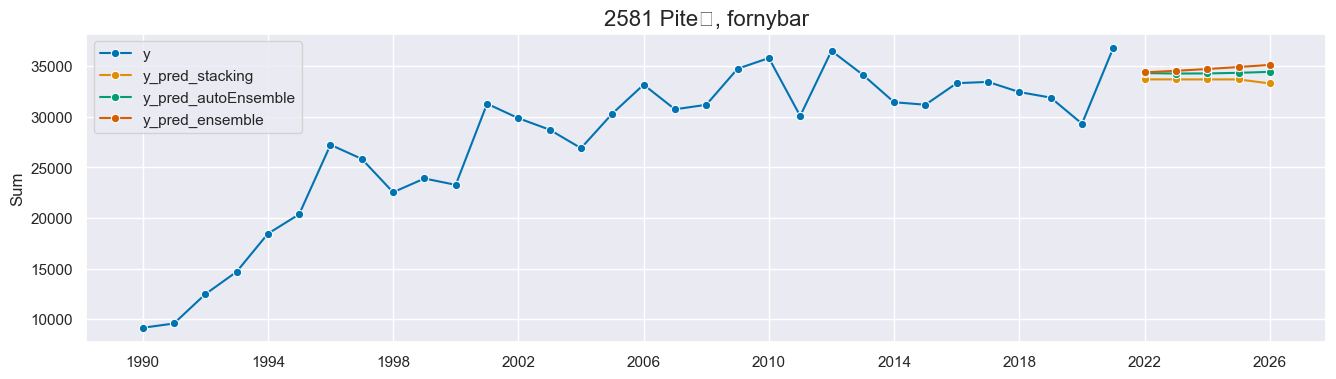

icke-fornybar
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


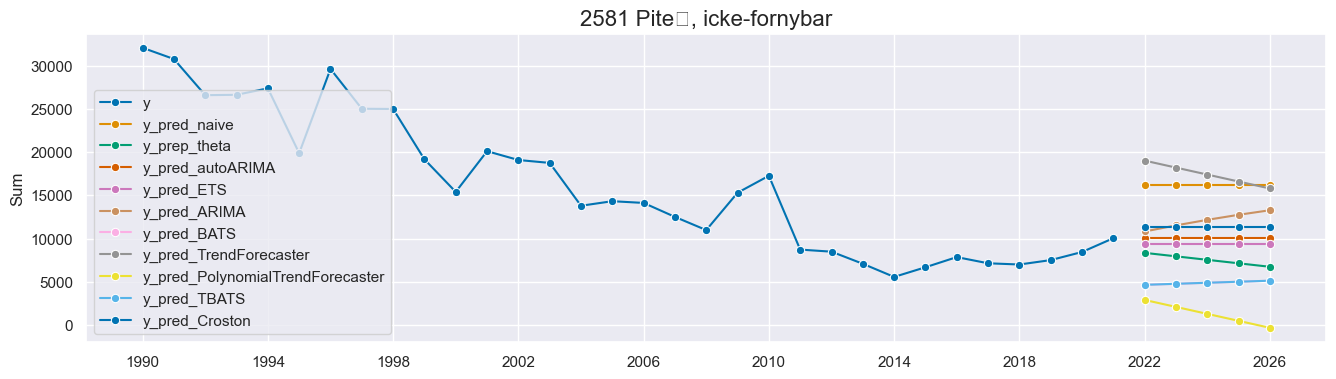

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


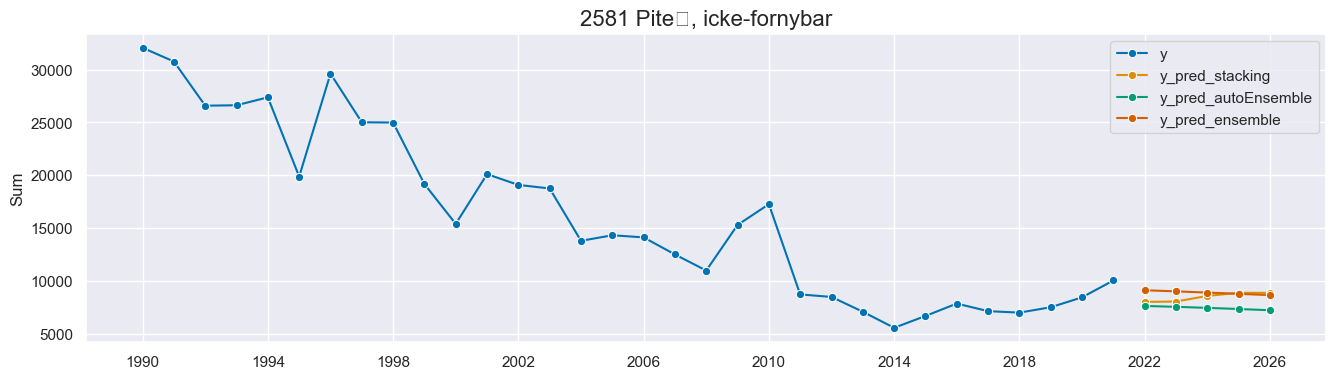

okand
frist�ende v�rmeverk


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


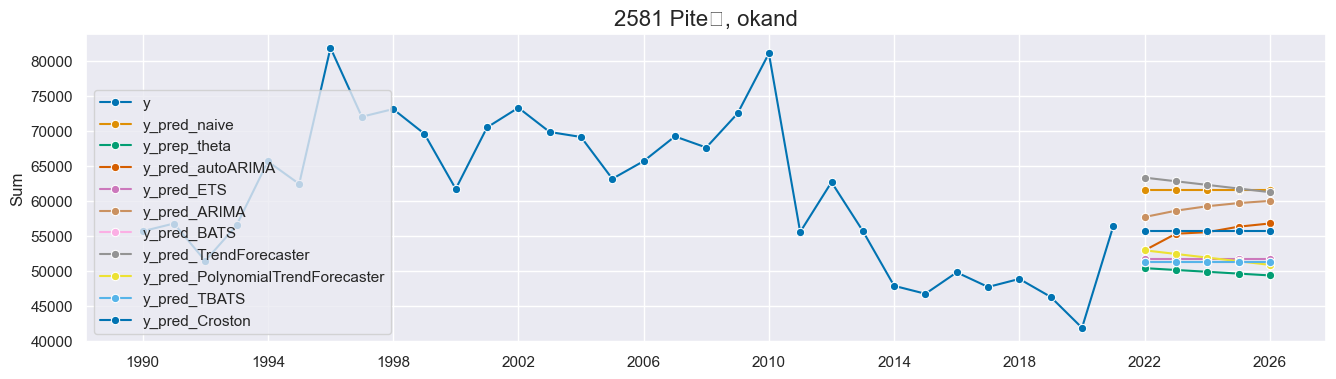

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

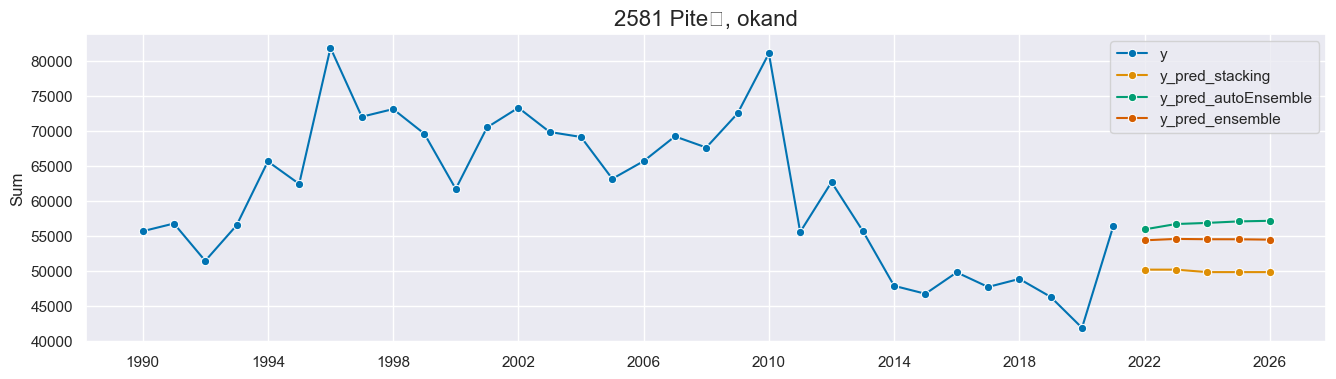

In [7]:
# bransleforbrukning


for fornybar_bransletyp in bransleforbrukning.fornybar_bransletyp.drop_duplicates(keep='first').reset_index(drop=True):
    data = bransleforbrukning[bransleforbrukning.fornybar_bransletyp == fornybar_bransletyp].reset_index(drop=True)    
    for produktionsslag in data.produktionsslag.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.produktionsslag == produktionsslag].reset_index(drop=True)
        if not data.empty:
            print(fornybar_bransletyp)
            print(produktionsslag)
            
            
            data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
            data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

            y = data[['Sum']].squeeze()

            # create forecasting horizon
            fh = ForecastingHorizon(
                    pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
            )
            
            # Instantiate NaiveForecaster:
            forecaster = NaiveForecaster(strategy='mean').fit(y)
            # Predict:
            y_pred = forecaster.predict(fh=fh)

            # Instantiate Theta:
            forecaster = ThetaForecaster(deseasonalize=False).fit(y)
            # Predict Theta:
            y_pred_theta = forecaster.predict(fh=fh)
            
            # Instantiate autoARIMA
            forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
            # Predict autoARIMA 
            y_pred_autoARIMA = forecaster.predict(fh)

            # Instantiate AutoETS
            forecaster = AutoETS(seasonal=None).fit(y)
            # Predict AutoETS 
            y_pred_ETS = forecaster.predict(fh)

            # Instantiate ARIMA
            forecaster = ARIMA(suppress_warnings=True).fit(y)
            # Predict ARIMA 
            y_pred_ARIMA = forecaster.predict(fh)

            # Instantiate BATS
            forecaster = BATS(show_warnings=False).fit(y)
            # Predict BATS 
            y_pred_BATS = forecaster.predict(fh)

            # Instantiate TrendForecaster
            forecaster = TrendForecaster().fit(y)
            # Predict TrendForecaster 
            y_pred_TrendForecaster = forecaster.predict(fh)

            # Instantiate PolynomialTrendForecaster
            forecaster = PolynomialTrendForecaster().fit(y)
            # Predict PolynomialTrendForecaster 
            y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
            
            # Instantiate TBATS
            forecaster = TBATS(show_warnings=False).fit(y)
            # Predict TBATS 
            y_pred_TBATS = forecaster.predict(fh)
            
            # Instantiate Croston
            forecaster = Croston().fit(y)
            # Predict Croston 
            y_pred_Croston = forecaster.predict(fh)
            
            # Check it out:
            fig = plot_series(y, y_pred, 
                                y_pred_theta, 
                                y_pred_autoARIMA, 
                                y_pred_ETS, y_pred_ARIMA, 
                                y_pred_BATS, 
                                y_pred_TrendForecaster, 
                                y_pred_PolynomialTrendForecaster, 
                                y_pred_TBATS, 
                                y_pred_Croston, 
                                labels=["y", "y_pred_naive", 
                                    "y_pred_theta", 
                                    "y_pred_autoARIMA", 
                                    "y_pred_ETS", 
                                    "y_pred_ARIMA", 
                                    "y_pred_BATS", 
                                    "y_pred_TrendForecaster", 
                                    "y_pred_PolynomialTrendForecaster", 
                                    "y_pred_TBATS", 
                                    "y_pred_Croston"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig) 
            
            forecasters = [
                ("NaiveForecaster", NaiveForecaster()),
                ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                ("AutoETS", AutoETS(seasonal=None)),
                ("ARIMA", ARIMA(suppress_warnings=True)),
                ("BATS", BATS(show_warnings=False)),
                ("TBATS", TBATS(show_warnings=False)),
                ("TrendForecaster", TrendForecaster()),
                ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                ("Croston", Croston()),
            ]

            # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
            stackingForecaster = StackingForecaster(forecasters=forecasters)
            stackingForecaster.fit(y=y, fh=fh)
            y_pred_stacking = stackingForecaster.predict()

            # Automatically find best weights for the ensembled forecasters.
            autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
            autoEnsembleForecaster.fit(y=y)
            y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

            # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
            ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
            ensembleForecaster.fit(y=y)
            y_pred_ensemble = ensembleForecaster.predict(fh=fh)

            # Check it out:
            fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
            plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
            plt.show(fig)


            # print("----------------")   

        # else:
        #     print("----------------")   


00 Riket
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmod

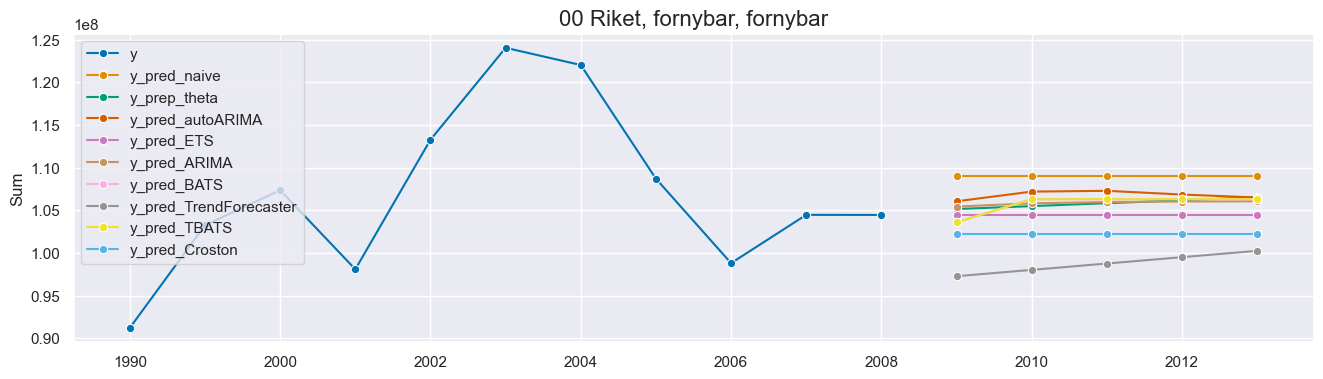

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

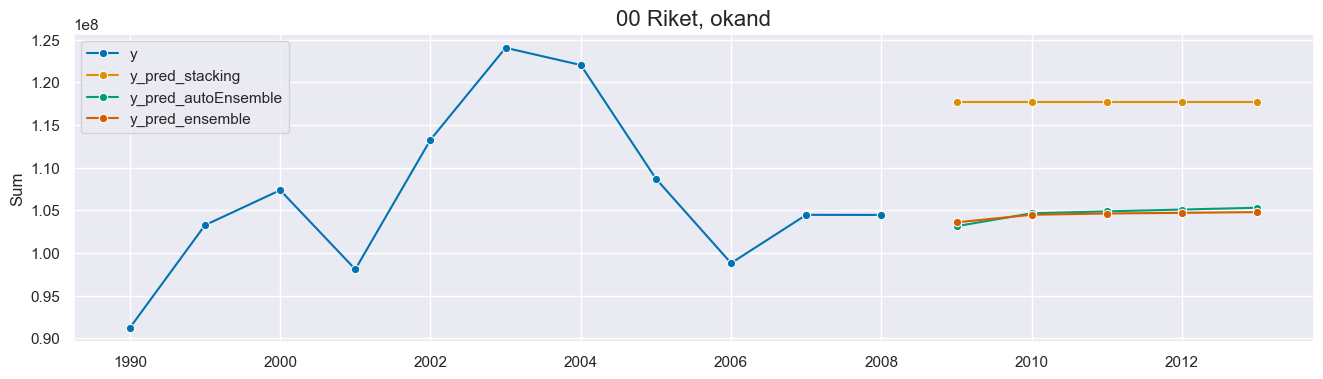

01 Stockholms l�n
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


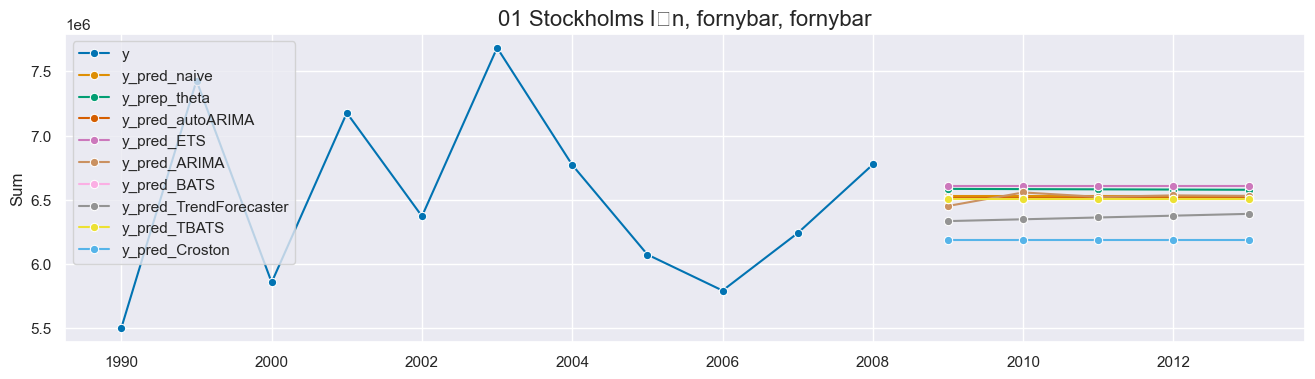

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(1,1,1)(0,0,0)[0] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Progra

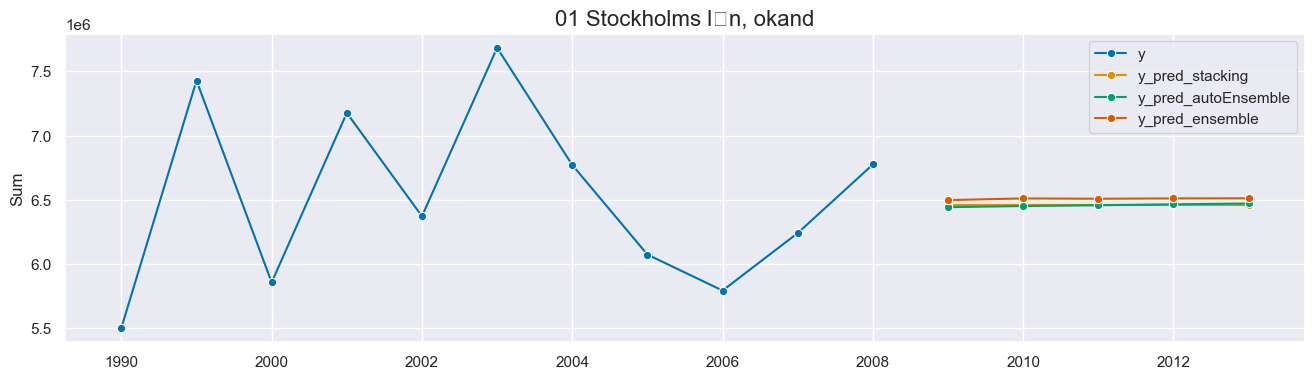

0117 �ster�ker
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


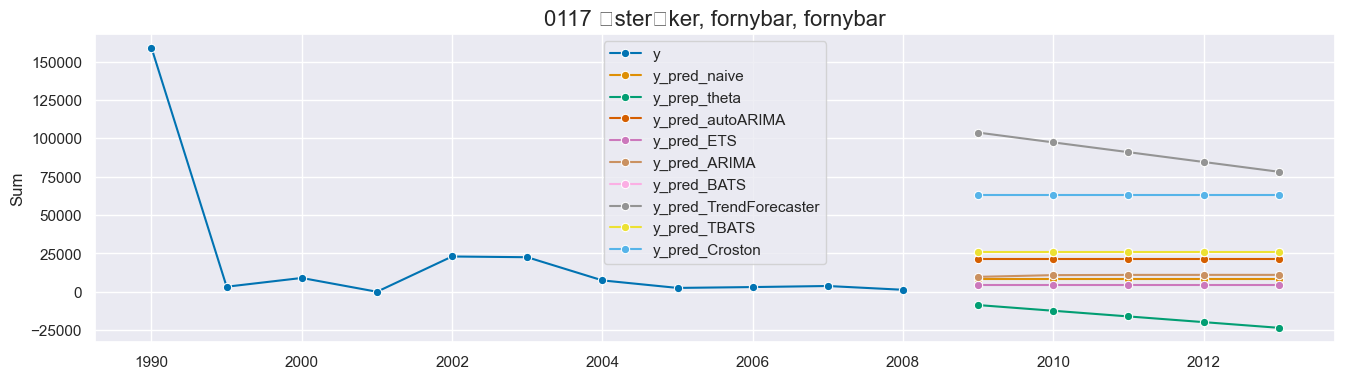

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

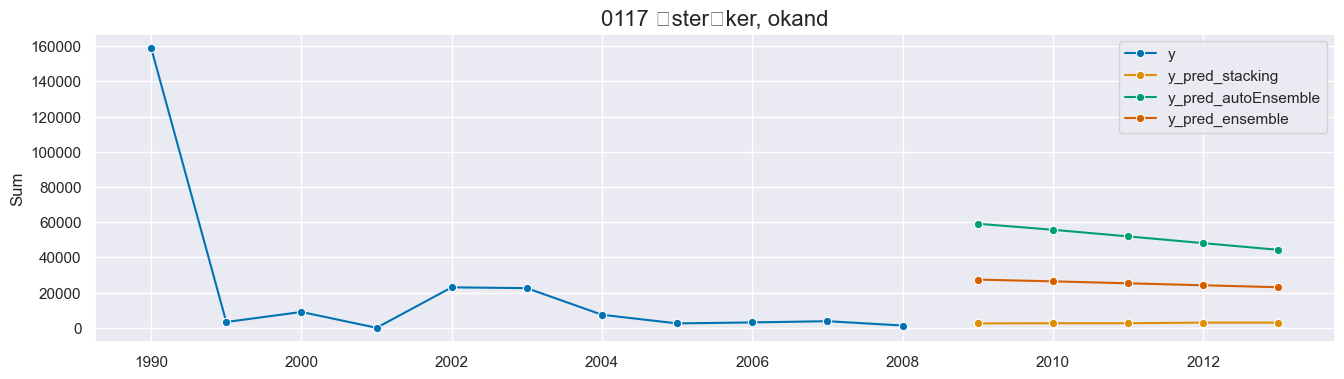

0160 T�by
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\s

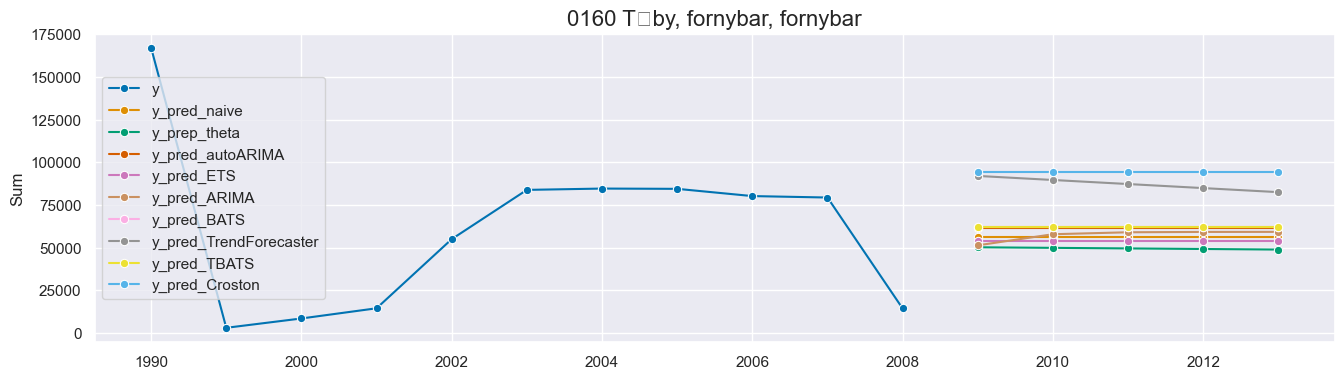

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

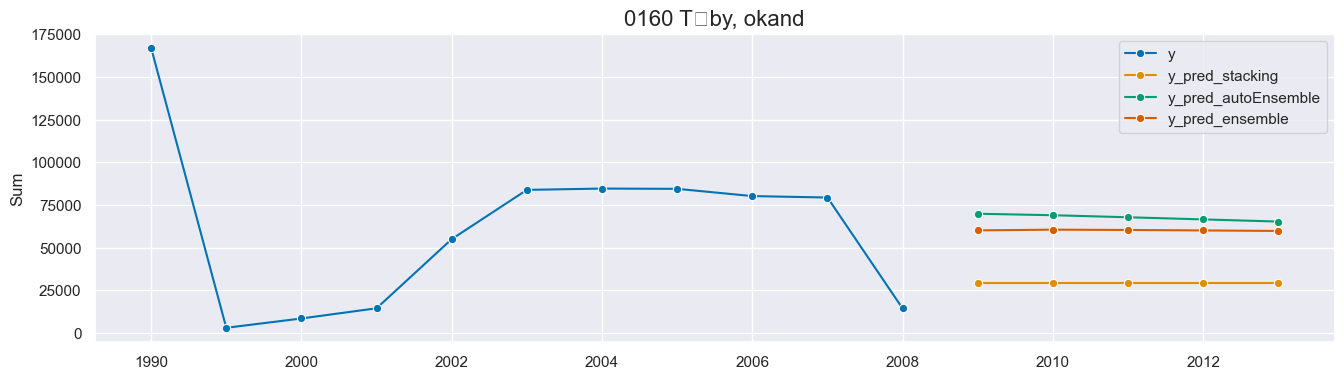

0180 Stockholm
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


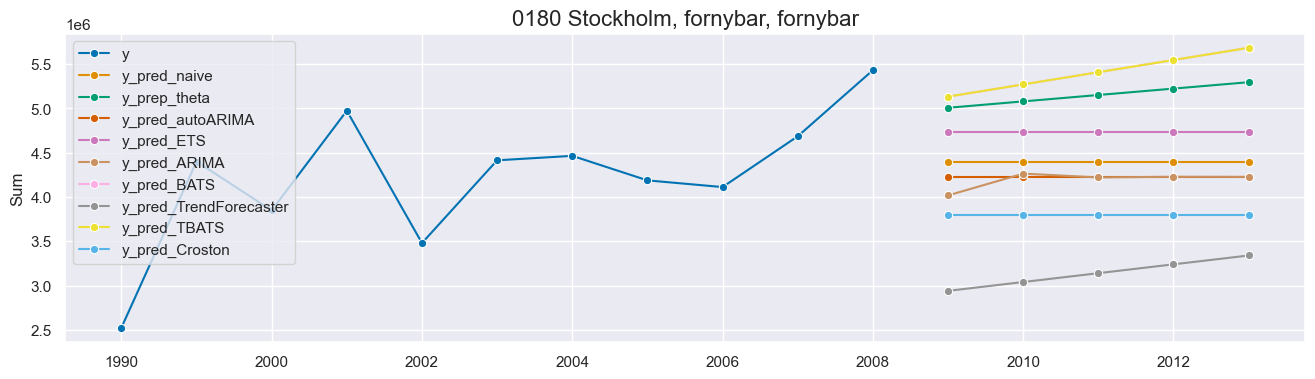

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

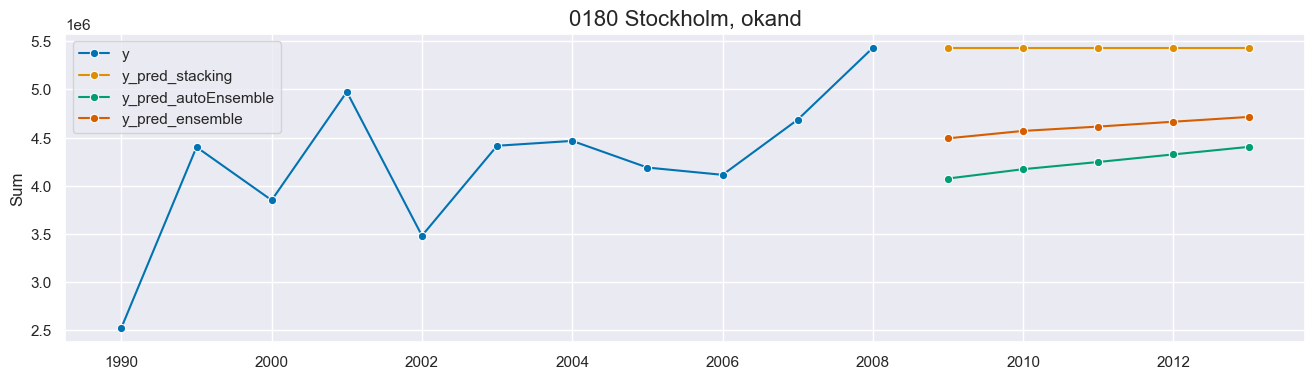

09 Gotlands l�n
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmod

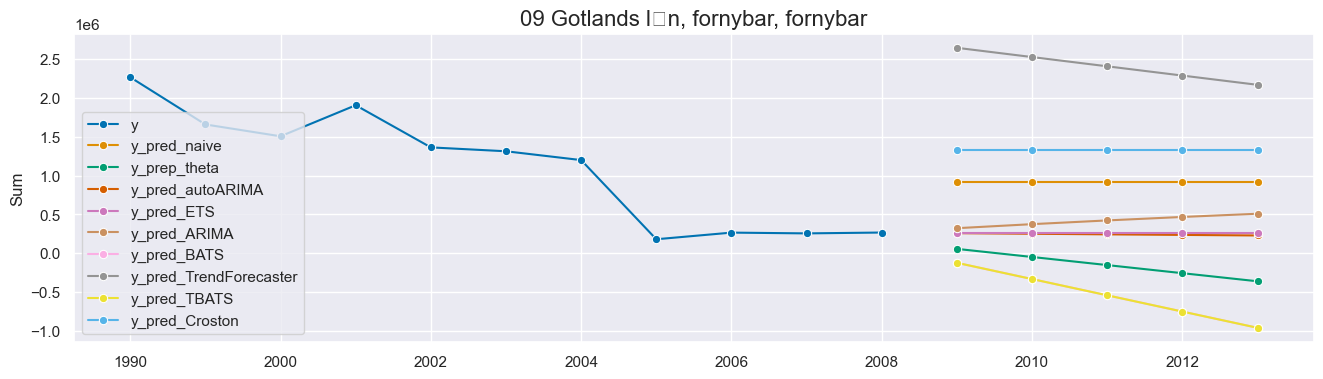

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

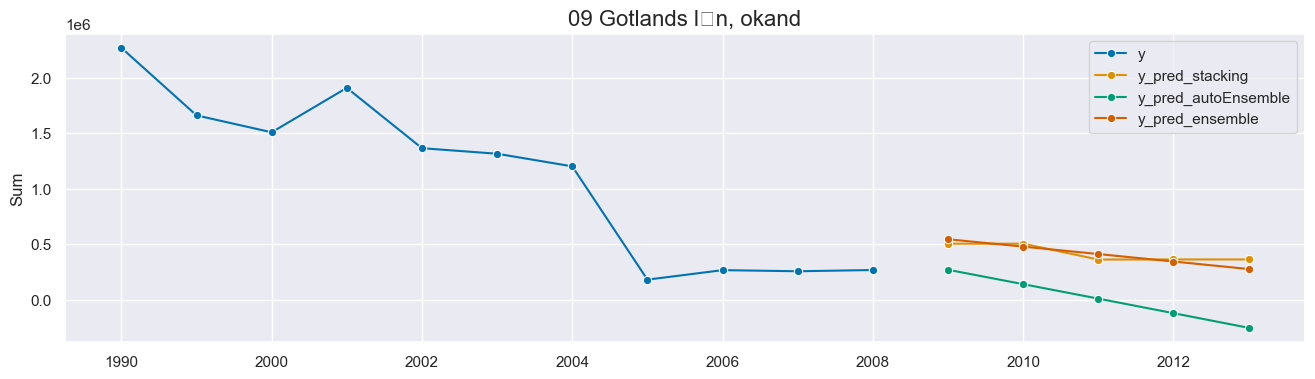

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0980 Gotland
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

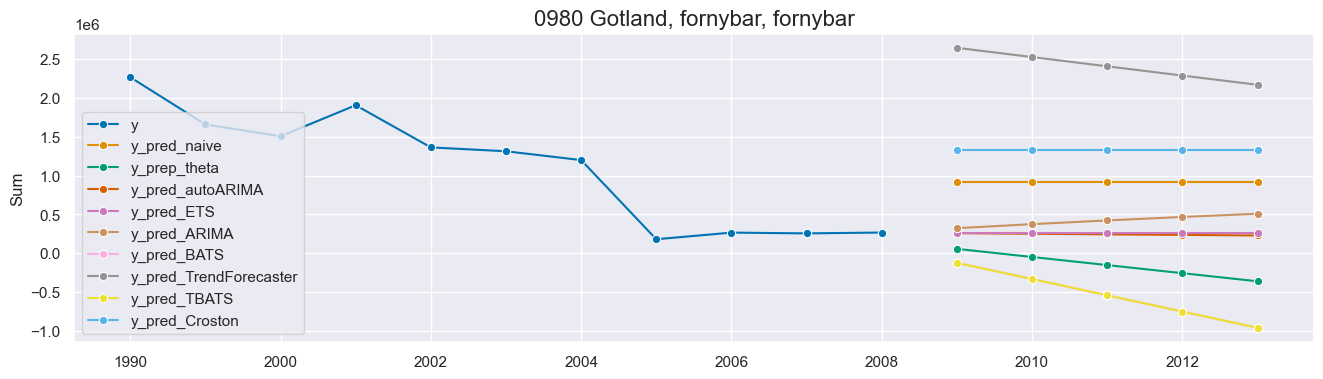

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

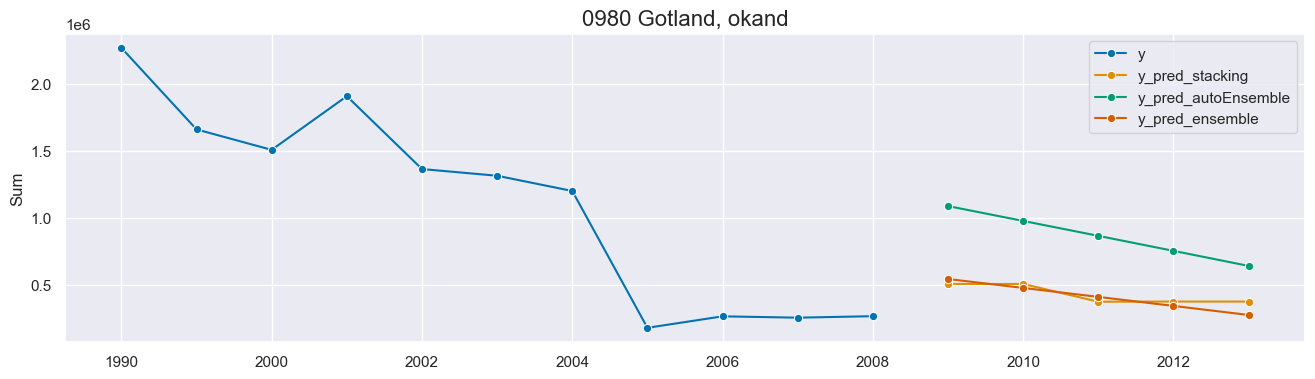

1480 G�teborg
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


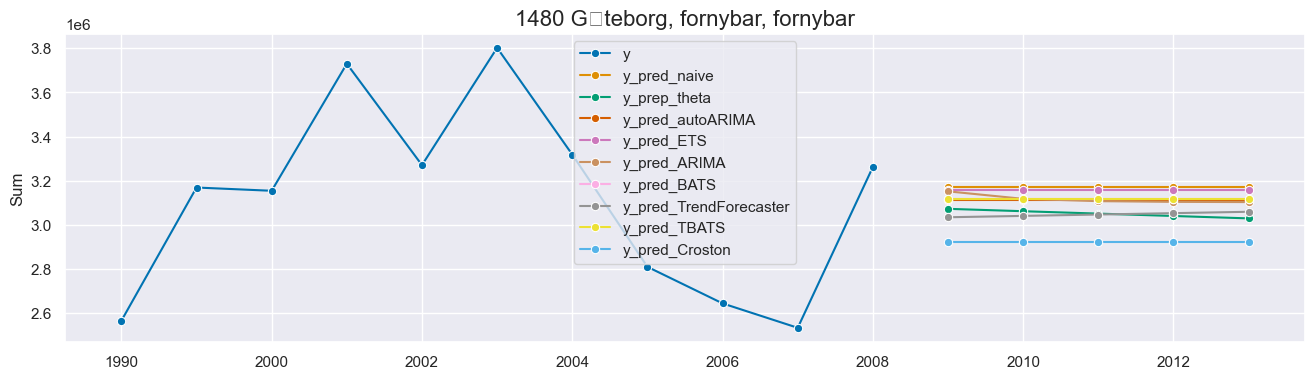

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

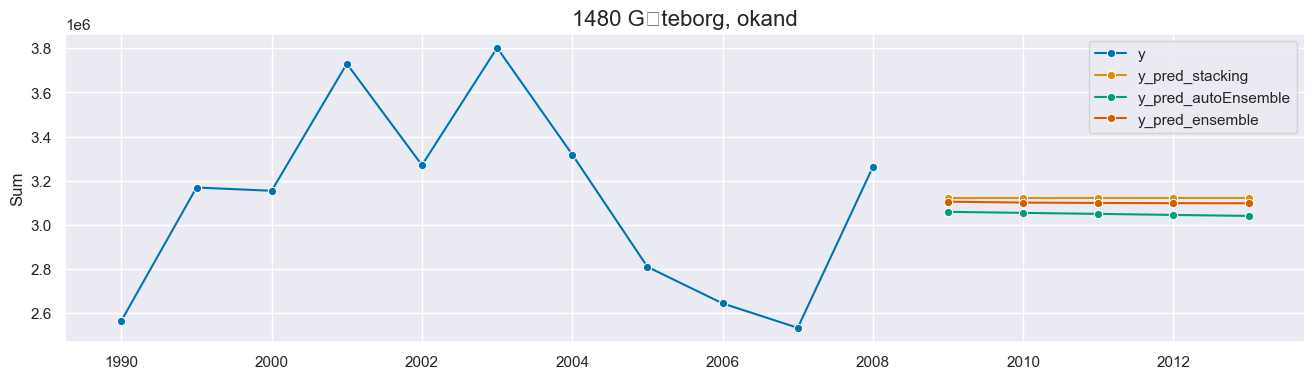

22 V�sternorrlands l�n
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\markella.nikolopoulo\AppData\Roaming\Python\Python310\s

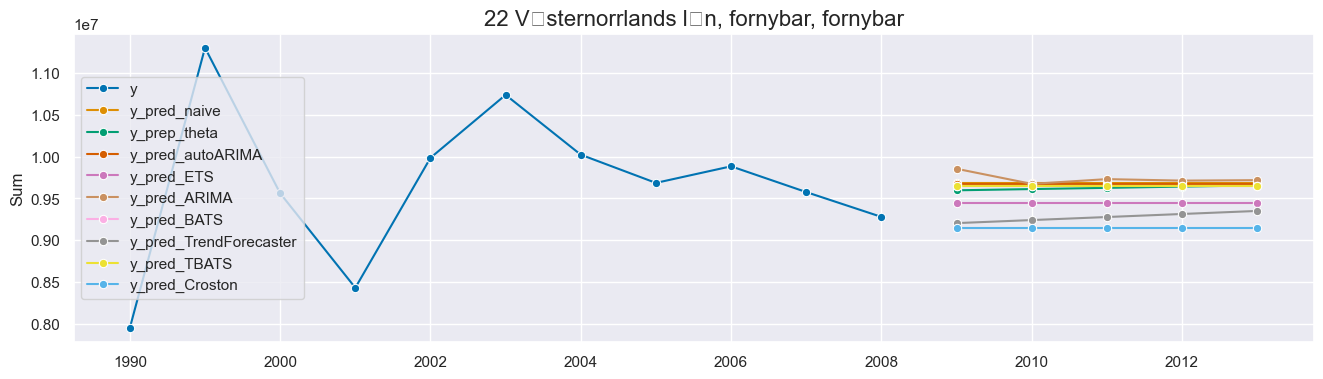

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

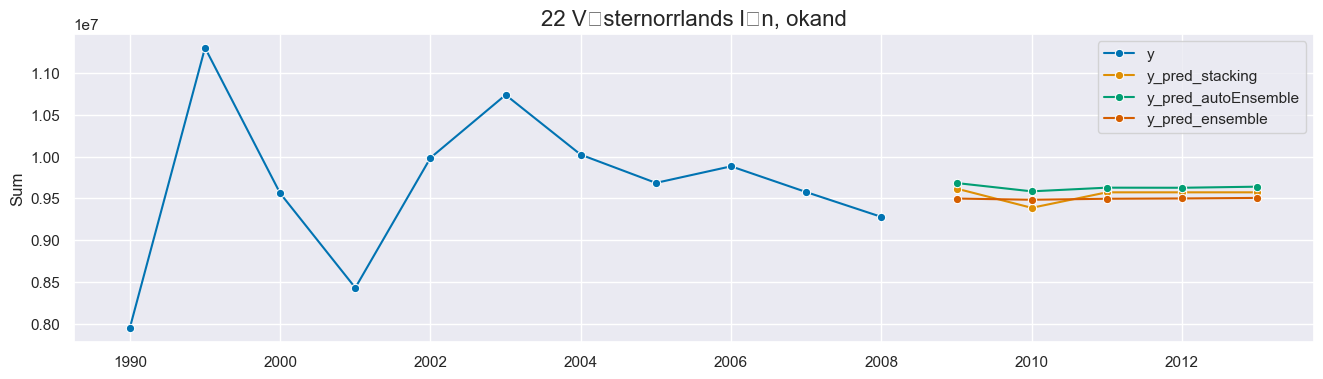

2581 Pite�
fornybar
fornybar


c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmod

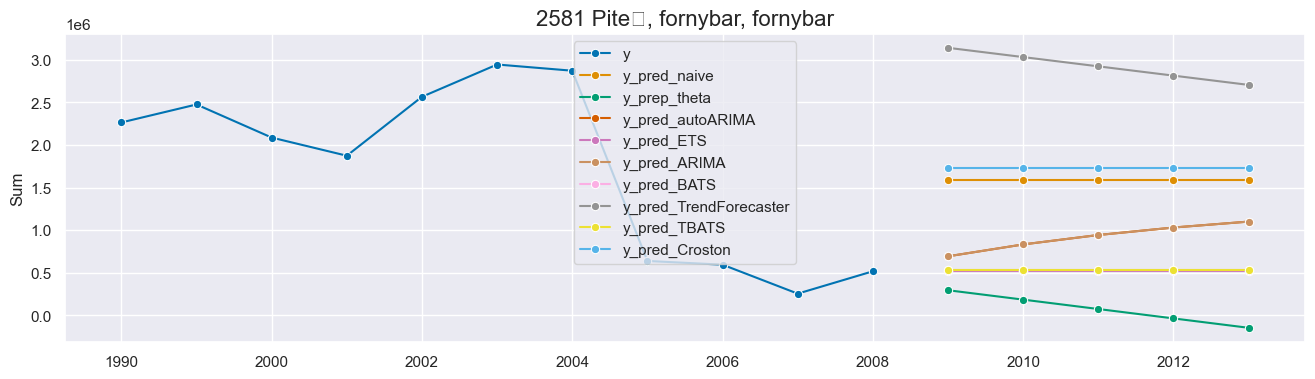

c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sktime\forecasting\model_selection\_split.py:1275: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(index=y[y <= y[train_end]]), window_length=window_length
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\thisone\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarnin

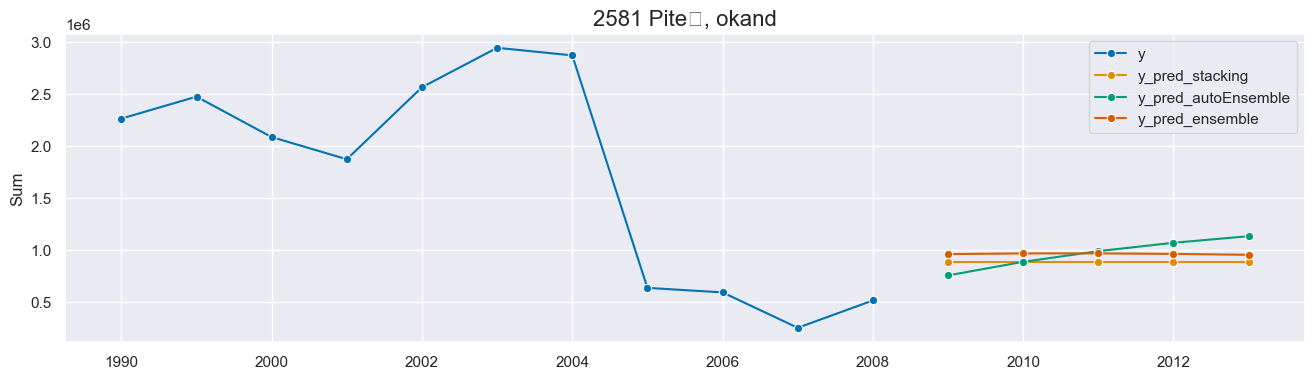

In [8]:
# energidata

for region in energidata.region.drop_duplicates(keep='first').reset_index(drop=True):
    data = energidata[energidata.region == region].reset_index(drop=True)    
    for fornybar_energityp in data.fornybar_energityp.drop_duplicates(keep='first').reset_index(drop=True):
        data = data[data.fornybar_energityp == fornybar_energityp].reset_index(drop=True)
        for fornybar_kategori in data.fornybar_kategori.drop_duplicates(keep='first').reset_index(drop=True):
            data = data[data.fornybar_kategori == fornybar_kategori].reset_index(drop=True)

            if not data.empty:
                print(region)
                print(fornybar_energityp)
                print(fornybar_kategori)

                data = data.sort_values(by='ar', ascending=True).set_index(['ar'])
                data.index = pd.to_datetime(data.index, format='%Y').to_period(freq='Y')

                y = data[['Sum']].squeeze()

                # create forecasting horizon
                fh = ForecastingHorizon(
                        pd.PeriodIndex(pd.date_range(y.index.max().to_timestamp() + pd.offsets.DateOffset(years=1), periods=5, freq="Y")), is_relative=False
                )
                
                # Instantiate NaiveForecaster:
                forecaster = NaiveForecaster(strategy='mean').fit(y)
                # Predict:
                y_pred = forecaster.predict(fh=fh)

                # Instantiate Theta:
                forecaster = ThetaForecaster(deseasonalize=False).fit(y)
                # Predict Theta:
                y_pred_theta = forecaster.predict(fh=fh)
                
                # Instantiate autoARIMA
                forecaster = AutoARIMA(suppress_warnings=True, seasonal=False).fit(y)
                # Predict autoARIMA 
                y_pred_autoARIMA = forecaster.predict(fh)

                # Instantiate AutoETS
                forecaster = AutoETS(seasonal=None).fit(y)
                # Predict AutoETS 
                y_pred_ETS = forecaster.predict(fh)

                # Instantiate ARIMA
                forecaster = ARIMA(suppress_warnings=True).fit(y)
                # Predict ARIMA 
                y_pred_ARIMA = forecaster.predict(fh)

                # Instantiate BATS
                forecaster = BATS(show_warnings=False).fit(y)
                # Predict BATS 
                y_pred_BATS = forecaster.predict(fh)

                # Instantiate TrendForecaster
                forecaster = TrendForecaster().fit(y)
                # Predict TrendForecaster 
                y_pred_TrendForecaster = forecaster.predict(fh)

                # # Instantiate PolynomialTrendForecaster
                # forecaster = PolynomialTrendForecaster().fit(y)
                # # Predict PolynomialTrendForecaster 
                # y_pred_PolynomialTrendForecaster = forecaster.predict(fh)
                
                # Instantiate TBATS
                forecaster = TBATS(show_warnings=False).fit(y)
                # Predict TBATS 
                y_pred_TBATS = forecaster.predict(fh)
                
                # Instantiate Croston
                forecaster = Croston().fit(y)
                # Predict Croston 
                y_pred_Croston = forecaster.predict(fh)
                
                # Check it out:
                fig = plot_series(y, y_pred, 
                        y_pred_theta, 
                        y_pred_autoARIMA, 
                        y_pred_ETS, 
                        y_pred_ARIMA, 
                        y_pred_BATS, 
                        y_pred_TrendForecaster, 
                        # y_pred_PolynomialTrendForecaster, 
                        y_pred_TBATS, 
                        y_pred_Croston, 
                        labels=["y", "y_pred_naive", 
                        "y_prep_theta", 
                        "y_pred_autoARIMA", 
                        "y_pred_ETS", 
                        "y_pred_ARIMA", 
                        "y_pred_BATS", 
                        "y_pred_TrendForecaster", 
                        # "y_pred_PolynomialTrendForecaster", 
                        "y_pred_TBATS", 
                        "y_pred_Croston"]) 
                plt.title("{}, {}, {}".format(region, fornybar_energityp, fornybar_kategori), fontsize=16)
                plt.show(fig)            
                

                forecasters = [
                    ("NaiveForecaster", NaiveForecaster()),
                    ("ThetaForecaster", ThetaForecaster(deseasonalize=False)),
                    ("AutoARIMA", AutoARIMA(suppress_warnings=True, seasonal=False)),
                    ("AutoETS", AutoETS(seasonal=None)),
                    ("ARIMA", ARIMA(suppress_warnings=True)),
                    ("BATS", BATS(show_warnings=False)),
                    ("TBATS", TBATS(show_warnings=False)),
                    ("TrendForecaster", TrendForecaster()),
                    # ("PolynomialTrendForecaster", PolynomialTrendForecaster()),
                    ("Croston", Croston()),
                ]

                # Stacks two or more Forecasters and uses a meta-model (regressor) to infer the final predictions from the predictions of the given forecasters.
                stackingForecaster = StackingForecaster(forecasters=forecasters)
                stackingForecaster.fit(y=y, fh=fh)
                y_pred_stacking = stackingForecaster.predict()

                # Automatically find best weights for the ensembled forecasters.
                autoEnsembleForecaster = AutoEnsembleForecaster(forecasters=forecasters)
                autoEnsembleForecaster.fit(y=y)
                y_pred_autoEnsemble = autoEnsembleForecaster.predict(fh=fh)

                # Overview: Input one series of length n and EnsembleForecaster performs fitting and prediction for each estimator passed in forecasters. It then applies aggfunc aggregation function by row to the predictions dataframe and returns final prediction - one series.
                ensembleForecaster = EnsembleForecaster(forecasters=forecasters)
                ensembleForecaster.fit(y=y)
                y_pred_ensemble = ensembleForecaster.predict(fh=fh)

                # Check it out:
                fig = plot_series(y, y_pred_stacking, y_pred_autoEnsemble,y_pred_ensemble, 
                                    labels=["y", "y_pred_stacking", "y_pred_autoEnsemble", "y_pred_ensemble"]) 
                plt.title("{}, {}".format(region, fornybar_bransletyp), fontsize=16)
                plt.show(fig)



                # print("----------------")   

            # else:
            #     print("----------------")   
